In [46]:
# All imports 
import random
import math 
import numpy as np
%matplotlib inline    
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.integrate import odeint
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import pandas as pd
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend



random.seed(2025)

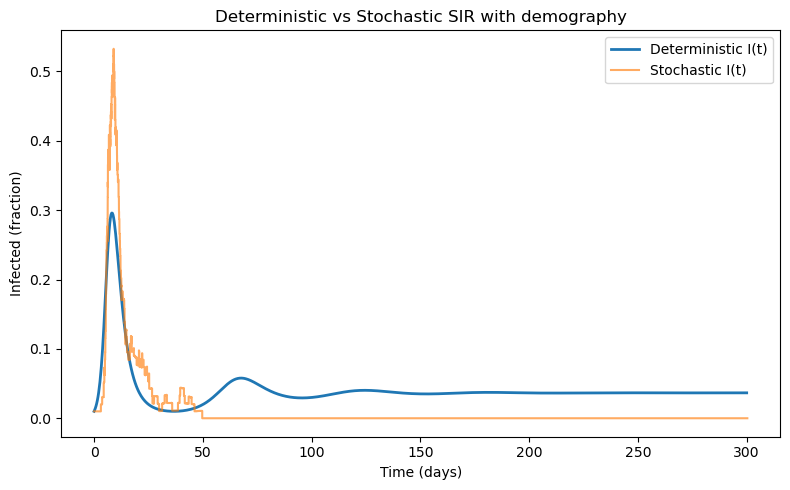

In [ ]:
# Implement Gillespies (Direct) Algorithm 


def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, nu, T_max, imp=False):
    """Gillespie (direct method) for SIR with demography; returns times and X,Y,Z lists.
    Parameters:
    X0, Y0, Z0 : initial counts of Susceptible, Infected, Recovered
    beta : infection rate
    gamma : recovery rate
    mu : per capita death rate
    nu : per capita birth rate
    T_max : maximum simulation time
    imp : boolean, if True includes importation of cases
    
    Returns:
    times : list of event times
    X_list : list of Susceptible counts over time
    Y_list : list of Infected counts over time
    Z_list : list of Recovered counts over time
    """
    
    # initial state
    X, Y, Z = X0, Y0, Z0
    t = 0.0
    R0 = beta / (gamma + mu)

    # initialize output lists
    times = [t]
    X_list, Y_list, Z_list = [X], [Y], [Z]

    # step 1: label all possible events 
    events = {
    "birth":     (+1,  0,  0),  
    "infection": (-1, +1,  0),   
    "recovery":  ( 0, -1, +1),  
    "death_S":   (-1,  0,  0),   
    "death_I":   ( 0, -1,  0),   
    "death_R":   ( 0,  0, -1),   
}
    if imp:
        events["import"] = (-1, +1, 0)

    while True:
        N = X + Y + Z

        # step 2: define event rates R_m
        birth_rate      = nu * N
        infection_rate  = beta * X * Y / N if N > 0 else 0.0
        recovery_rate   = gamma * Y
        deathS_rate     = mu * X
        deathI_rate     = mu * Y
        deathR_rate     = mu * Z
        import_rate     = 1.7e-7 * X
   
        rates = [birth_rate, infection_rate, recovery_rate,
                 deathS_rate, deathI_rate, deathR_rate]
        names = ["birth", "infection", "recovery", "death_S", "death_I", "death_R"]

        if imp and X > 0:
            rates.append(import_rate)
            names.append("import")

        # step 3: calculate the total rate
        R_total = sum(rates)
        if R_total <= 0.0:
            break  

        # step 4: set time until next event
        u1 = random.random()
        dt = -math.log(u1) / R_total

        # step 5: draw second random number and set P
        u2 = random.random()
        P = u2 * R_total

        # step 6: choose event p by cumulative rates an apply it 
        cumulative = 0.0
        event = None
        for k, r in enumerate(rates):
            cumulative += r
            if P <= cumulative:
                event = names[k]
                break

        # step 7; update time and states 
        dX, dY, dZ = events[event]
        X += dX; Y += dY; Z += dZ

        t += dt
        times.append(t)
        X_list.append(X)
        Y_list.append(Y)
        Z_list.append(Z)

        # step 8: return to step 2
        if t >= T_max:
            break
        
        # do not stop if importations are considered
        if Y == 0 and infection_rate == 0.0 and not imp:
            break

    return times, X_list, Y_list, Z_list

# Deterministic SIR
def sir_ode(y, t, beta, gamma, mu, nu):
    S, I, R = y
    dSdt = nu - beta*S*I - mu*S
    dIdt = beta*S*I - (gamma + mu)*I
    dRdt = gamma*I - mu*R
    return [dSdt, dIdt, dRdt]

# Compare stochastic vs deterministic 
beta = 1
gamma = 1 / 3
mu = nu = 1 / 50
T_max = 300

N0 = 1000
X0, Y0, Z0 = 999, 1, 0
y0 = [X0/N0, Y0/N0, Z0/N0]

# deterministic
t_det = np.linspace(0, T_max, 1000)
sol = odeint(sir_ode, y0, t_det, args=(beta, gamma, mu, nu))
S_det, I_det, R_det = sol.T

# stochastic
t_sto, X_sto, Y_sto, Z_sto = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, nu, T_max, True)

# convert counts into fractions for comparison 
I_sto_frac = [i/(x+i+z) for x, i, z in zip(X_sto, Y_sto, Z_sto)]

# plot I(t)
plt.figure(figsize=(8,5), dpi=300)
plt.plot(t_det, I_det, lw=2, label='Deterministic I(t)')
plt.step(t_sto, I_sto_frac, where='post', alpha=0.65, label='Stochastic I(t)')
plt.xlabel('Time (days)'); plt.ylabel('Infected (fraction)')
plt.title('Deterministic vs Stochastic SIR with demography')
plt.legend(); plt.tight_layout(); plt.show()




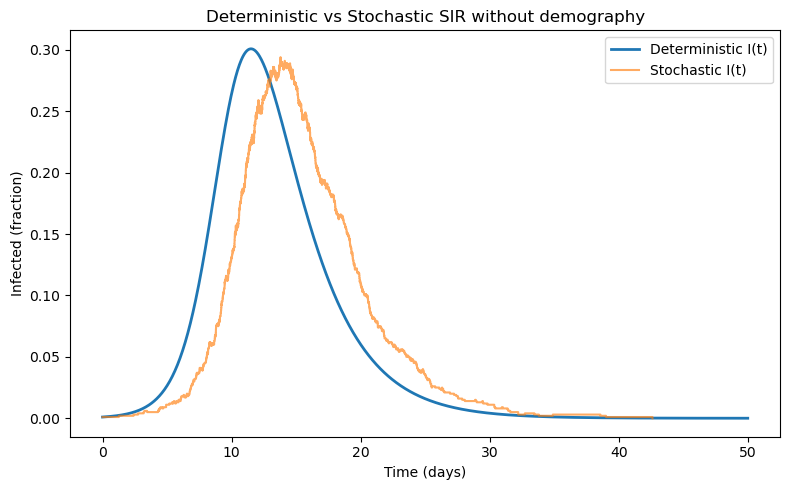

In [48]:
# Implement Gillespies (Direct) Algorithm 


def gillespie_sir_no_demo(X0, Y0, Z0, beta, gamma, T_max, imp=False):
    """Gillespie (direct method) for SIR without demography; returns times and X,Y,Z lists."""
    
    X, Y, Z = X0, Y0, Z0
    t = 0.0
    R0 = beta / gamma

    times = [t]
    X_list, Y_list, Z_list = [X], [Y], [Z]

    # step 1: label all possible events 
    events = {  
    "infection": (-1, +1,  0),   
    "recovery":  ( 0, -1, +1),    
}
    if imp:
        events["import"] = (-1, +1, 0)

    while True:
        N = X + Y + Z

        # step 2: define event rates R_m
        
        infection_rate  = beta * X * Y / N if N > 0 else 0.0
        recovery_rate   = gamma * Y
        import_rate = 5e-5 * X

        rates = [infection_rate, recovery_rate]
        names = ["infection", "recovery"]

        if imp and X > 0:
            rates.append(import_rate)
            names.append("import")

        # step 3: calculate the total rate
        R_total = sum(rates)
        if R_total <= 0.0:
            break  

        # step 4: set time until next event
        u1 = random.random()
        dt = -math.log(u1) / R_total

        # step 5: draw second random number and set P
        u2 = random.random()
        P = u2 * R_total

        # step 6: choose event p by cumulative rates an apply it 
        cumulative = 0.0
        event = None
        for k, r in enumerate(rates):
            cumulative += r
            if P <= cumulative:
                event = names[k]
                break

        # step 7; update time and states 
        dX, dY, dZ = events[event]
        X += dX; Y += dY; Z += dZ

        t += dt
        times.append(t)
        X_list.append(X)
        Y_list.append(Y)
        Z_list.append(Z)

        # step 8: return to step 2
        if t >= T_max:
            break
        if Y == 0 and infection_rate == 0.0 and not imp:
            break

    return times, X_list, Y_list, Z_list

# Deterministic SIR
def sir_ode_no_demo(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta*S*I
    dIdt = beta*S*I - gamma*I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]

# Compare stochastic vs deterministic 
beta = 1
gamma = 1 / 3
mu = nu = 1 / 50
T_max = 300
eta = 1/50

N0 = 1000
X0, Y0, Z0 = 999, 1, 0
y0 = [X0/N0, Y0/N0, Z0/N0]

# deterministic
t_det = np.linspace(0, 50, 1000)
sol = odeint(sir_ode_no_demo, y0, t_det, args=(beta, gamma))
S_det, I_det, R_det = sol.T

# stochastic
t_sto, X_sto, Y_sto, Z_sto = gillespie_sir_no_demo(X0, Y0, Z0, beta, gamma, T_max)

# convert counts into fractions for comparison 
I_sto_frac = [i/(x+i+z) for x, i, z in zip(X_sto, Y_sto, Z_sto)]

# plot I(t)
plt.figure(figsize=(8,5))
plt.plot(t_det, I_det, lw=2, label='Deterministic I(t)')
plt.step(t_sto, I_sto_frac, where='post', alpha=0.65, label='Stochastic I(t)')
plt.xlabel('Time (days)'); plt.ylabel('Infected (fraction)')
plt.title('Deterministic vs Stochastic SIR without demography')
plt.legend(); plt.tight_layout(); plt.show()




In [49]:
# Investigate Simulation Variability and Negative Co-variance
def run_gillespie(initial_state, beta, gamma, mu, nu, t_max, n_runs, demography=True, imp=False):
    """
    Run multiple Gillespie SIR simulations and return trajectories on a common time grid.
    Parameters:
    initial_state : tuple (X0, Y0, Z0) initial counts
    beta : infection rate
    gamma : recovery rate
    mu : per capita death rate
    nu : per capita birth rate
    t_max : maximum simulation time
    n_runs : number of simulation runs
    demography : boolean, if True includes demography
    imp : boolean, if True includes importation of cases
    
    Returns:
    grid : common time grid
    all_trajectories : array of shape (n_runs, len(grid), 3) with X,Y,Z trajectories
    """
    X, Y, Z = initial_state
    
    # common time grid
    grid = np.arange(0, t_max + 0.5, 0.5)
    all_trajectories = np.zeros((n_runs, len(grid), 3))

    # results = np.zeros(N, )
    for i in range(n_runs):
        if demography and imp:
            t_list, X_list, Y_list, Z_list = gillespie_sir(X, Y, Z, beta, gamma, mu, nu, t_max, True)
        elif demography:
            t_list, X_list, Y_list, Z_list = gillespie_sir(X, Y, Z, beta, gamma, mu, nu, t_max)
        elif imp:
            t_list, X_list, Y_list, Z_list = gillespie_sir_no_demo(X, Y, Z, beta, gamma, t_max, True)
        else:
            t_list, X_list, Y_list, Z_list = gillespie_sir_no_demo(X, Y, Z, beta, gamma, t_max)

        
        # indices of last event time <= each grid time
        idx = np.searchsorted(np.asarray(t_list), grid, side='right') - 1
        
        # if first event happens after t = 0.5
        idx = np.clip(idx, 0, len(t_list)-1)  

        X_grid = np.asarray(X_list)[idx]
        Y_grid = np.asarray(Y_list)[idx]
        Z_grid = np.asarray(Z_list)[idx]
        
        all_trajectories[i, :, 0] = X_grid
        all_trajectories[i, :, 1] = Y_grid 
        all_trajectories[i, :, 2] = Z_grid 
        
        
    return grid, all_trajectories


In [50]:
def summary_stats(t_grid, all_trajectories):
    """
    Compute summary statistics from multiple Gillespie SIR trajectories.
    Parameters:
    t_grid : common time grid
    all_trajectories : array of shape (n_runs, len(t_grid),
    
    Returns:
    dict with means, variances, and covariance of S, I, R over time
    """
    X = all_trajectories[:,:,0]
    Y = all_trajectories[:,:,1]
    Z = all_trajectories[:,:,2]
    N = X + Y + Z

    # normalize to fractions for better comparison ODE
    s = X / N
    i = Y / N
    r = Z / N

    # means
    st_mean = np.mean(s, axis=0)
    it_mean = np.mean(i, axis=0)
    rt_mean = np.mean(r, axis=0)

    # sample variance
    s_var = s.var(axis=0, ddof=1)
    i_var = i.var(axis=0, ddof=1)
    r_var = r.var(axis=0, ddof=1)

    # covariance
    si_cov = np.array([np.cov(s[:, j], i[:, j], ddof=1)[0, 1] for j in range(s.shape[1])])
    
    return {'t': t_grid, 's_mean': st_mean, 'i_mean': it_mean, 'r_mean': rt_mean,
            's_var': s_var, 'i_var': i_var, 'r_var': r_var, 'si_cov': si_cov}





In [51]:
def parameter_sweep(parameter, values, initial_state, T_max, n_runs, imp=False):
    """
    This function performs a parameter sweep for the Gillespie SIR model with demography.
    Parameters:
    parameter : str, the parameter to vary ("beta", "gamma", "mu", "nu", "N")
    values : list of values for the parameter
    initial_state : tuple (X0, Y0, Z0) initial counts
    T_max : maximum simulation time
    n_runs : number of simulation runs
    imp : boolean, if True includes importation of cases
    
    Returns:
    dict mapping each parameter value to simulation results and summary statistics
    """
    results = {}

    # loop over parameter values
    for val in values:
        params = {
        "beta": 1,
        "gamma": 1/3,
        "mu" : 1/50,
        "nu" : 1/50,
        "N" : 1000
        }

        # set initial state and update parameter
        X, Y, Z = initial_state
        params[parameter] = val
        
        # adjust initial state if parameter is N
        if parameter == "N":
            X = 0.99 * val
            Y = 0.01 * val
        
        # adjust nu if parameter is mu
        if parameter == "mu":
            params['nu'] = val
        
        # run simulations
        grid, all_traj = run_gillespie(
            initial_state=(X, Y, Z),
            beta=params["beta"],
            gamma=params["gamma"],
            mu=params["mu"],
            nu=params["nu"],
            t_max=T_max,
            n_runs=n_runs,
            imp = True if imp else False
        )
        stats = summary_stats(grid, all_traj)

        # solve deterministic ODE for comparison
        N = X + Y + Z
        y0 = np.array([X/N, Y/N, Z/N])
        t_ode = np.linspace(0, T_max, 1000)
        solved = odeint(sir_ode, y0, t_ode, args=(params["beta"], params["gamma"], params["mu"], params["nu"]))
        S_det, I_det, R_det = solved.T  

        results[val] = {
            "params": params,
            "init_state": (X, Y, Z),
            "grid": grid,                   
            "traj": all_traj,               
            "stats": stats,                 
            "ode_t": t_ode,                 
            "ode_SIR": (S_det, I_det, R_det)  
        }
    return results
        

        


In [52]:
# perform parameter sweep over beta
beta_sweep = parameter_sweep(
    parameter="beta",
    values=[0.5, 1.0, 10],
    initial_state=(990, 10, 0),
    T_max=150,
    n_runs=300
)


In [53]:
# perform parameter sweep over N
N_sweep = parameter_sweep(
    parameter="N",
    values=[100, 1000, 10000, 100000],      
    initial_state=(990, 10, 0),
    T_max=150,
    n_runs=300
)

In [54]:
# perform parameter sweep over mu
mu_sweep = parameter_sweep(
    parameter="mu",
    values=[1/500, 1/50, 1/20, 1/10],      
    initial_state=(990, 10, 0),
    T_max=150,
    n_runs=300
)

In [55]:
def plot_sweep(parameter_name, title, results):
    """
    Plot results from parameter sweep.
    
    Parameters:
    parameter_name : str, name of the parameter varied
    title : str, title for the plots
    results : dict, output from parameter_sweep function
    
    Returns:
    fig, axes : matplotlib figure and axes objects
    """
    # extract parameter values
    vals = results.keys()
    fig, axes = plt.subplots(2, 1, dpi=300, figsize=(6,8),sharex=True)
    colors = ["lightcoral", "limegreen", "lightskyblue", "fuchsia"]
    
    # plot mean infected fraction and covariance
    for c, val in enumerate(vals):
        item = results[val]
        t = item["grid"]
        i_sto = item["stats"]["i_mean"]
        
        # compute standard deviation from variance
        i_sd = np.sqrt(item["stats"]["i_var"])
        si_cov = item["stats"]["si_cov"]

        t_ode = item["ode_t"]
        i_ode = item["ode_SIR"][1]
        
        # plot mean infected fraction with ODE comparison
        axes[0].plot(t, i_sto, label=f"{parameter_name}: {val}", lw=0.8, color=colors[c])
        axes[0].plot(t_ode, i_ode, ls='--', lw=0.5, color=colors[c])
        axes[0].fill_between(t, i_sto - i_sd, i_sto + i_sd, alpha=0.15, linewidth=0, color=colors[c])

        axes[1].plot(t, si_cov, lw=1, label=f"{parameter_name}: {val}", color=colors[c])
    
    # finalize plots
    axes[0].set_title("Mean infected fraction vs ODE")
    axes[0].set_xlabel("time"); axes[0].set_ylabel("infected fraction")
    axes[0].grid(alpha=0.3)
    
    # add deterministic label to legend
    axes[0].plot([], [], ls='--', color='k', label='Deterministic')
    axes[0].legend(frameon=False)

    axes[1].set_title(r" Covariance of fractions  $\mathrm{Cov}(s,i)(t)$")
    axes[1].set_xlabel("time"); axes[1].set_ylabel(r"$\mathrm{Cov}(s,i)$")
    axes[1].axhline(0, color='k', lw=1, alpha=0.4)
    axes[1].grid(alpha=0.3)
    axes[1].legend(frameon=False, fontsize=9)

    fig.suptitle(title, y=1.02, fontsize=13)
    fig.tight_layout()
    return fig, axes

(<Figure size 1800x2400 with 2 Axes>,
 array([<Axes: title={'center': 'Mean infected fraction vs ODE'}, xlabel='time', ylabel='infected fraction'>,
        <Axes: title={'center': ' Covariance of fractions  $\\mathrm{Cov}(s,i)(t)$'}, xlabel='time', ylabel='$\\mathrm{Cov}(s,i)$'>],
       dtype=object))

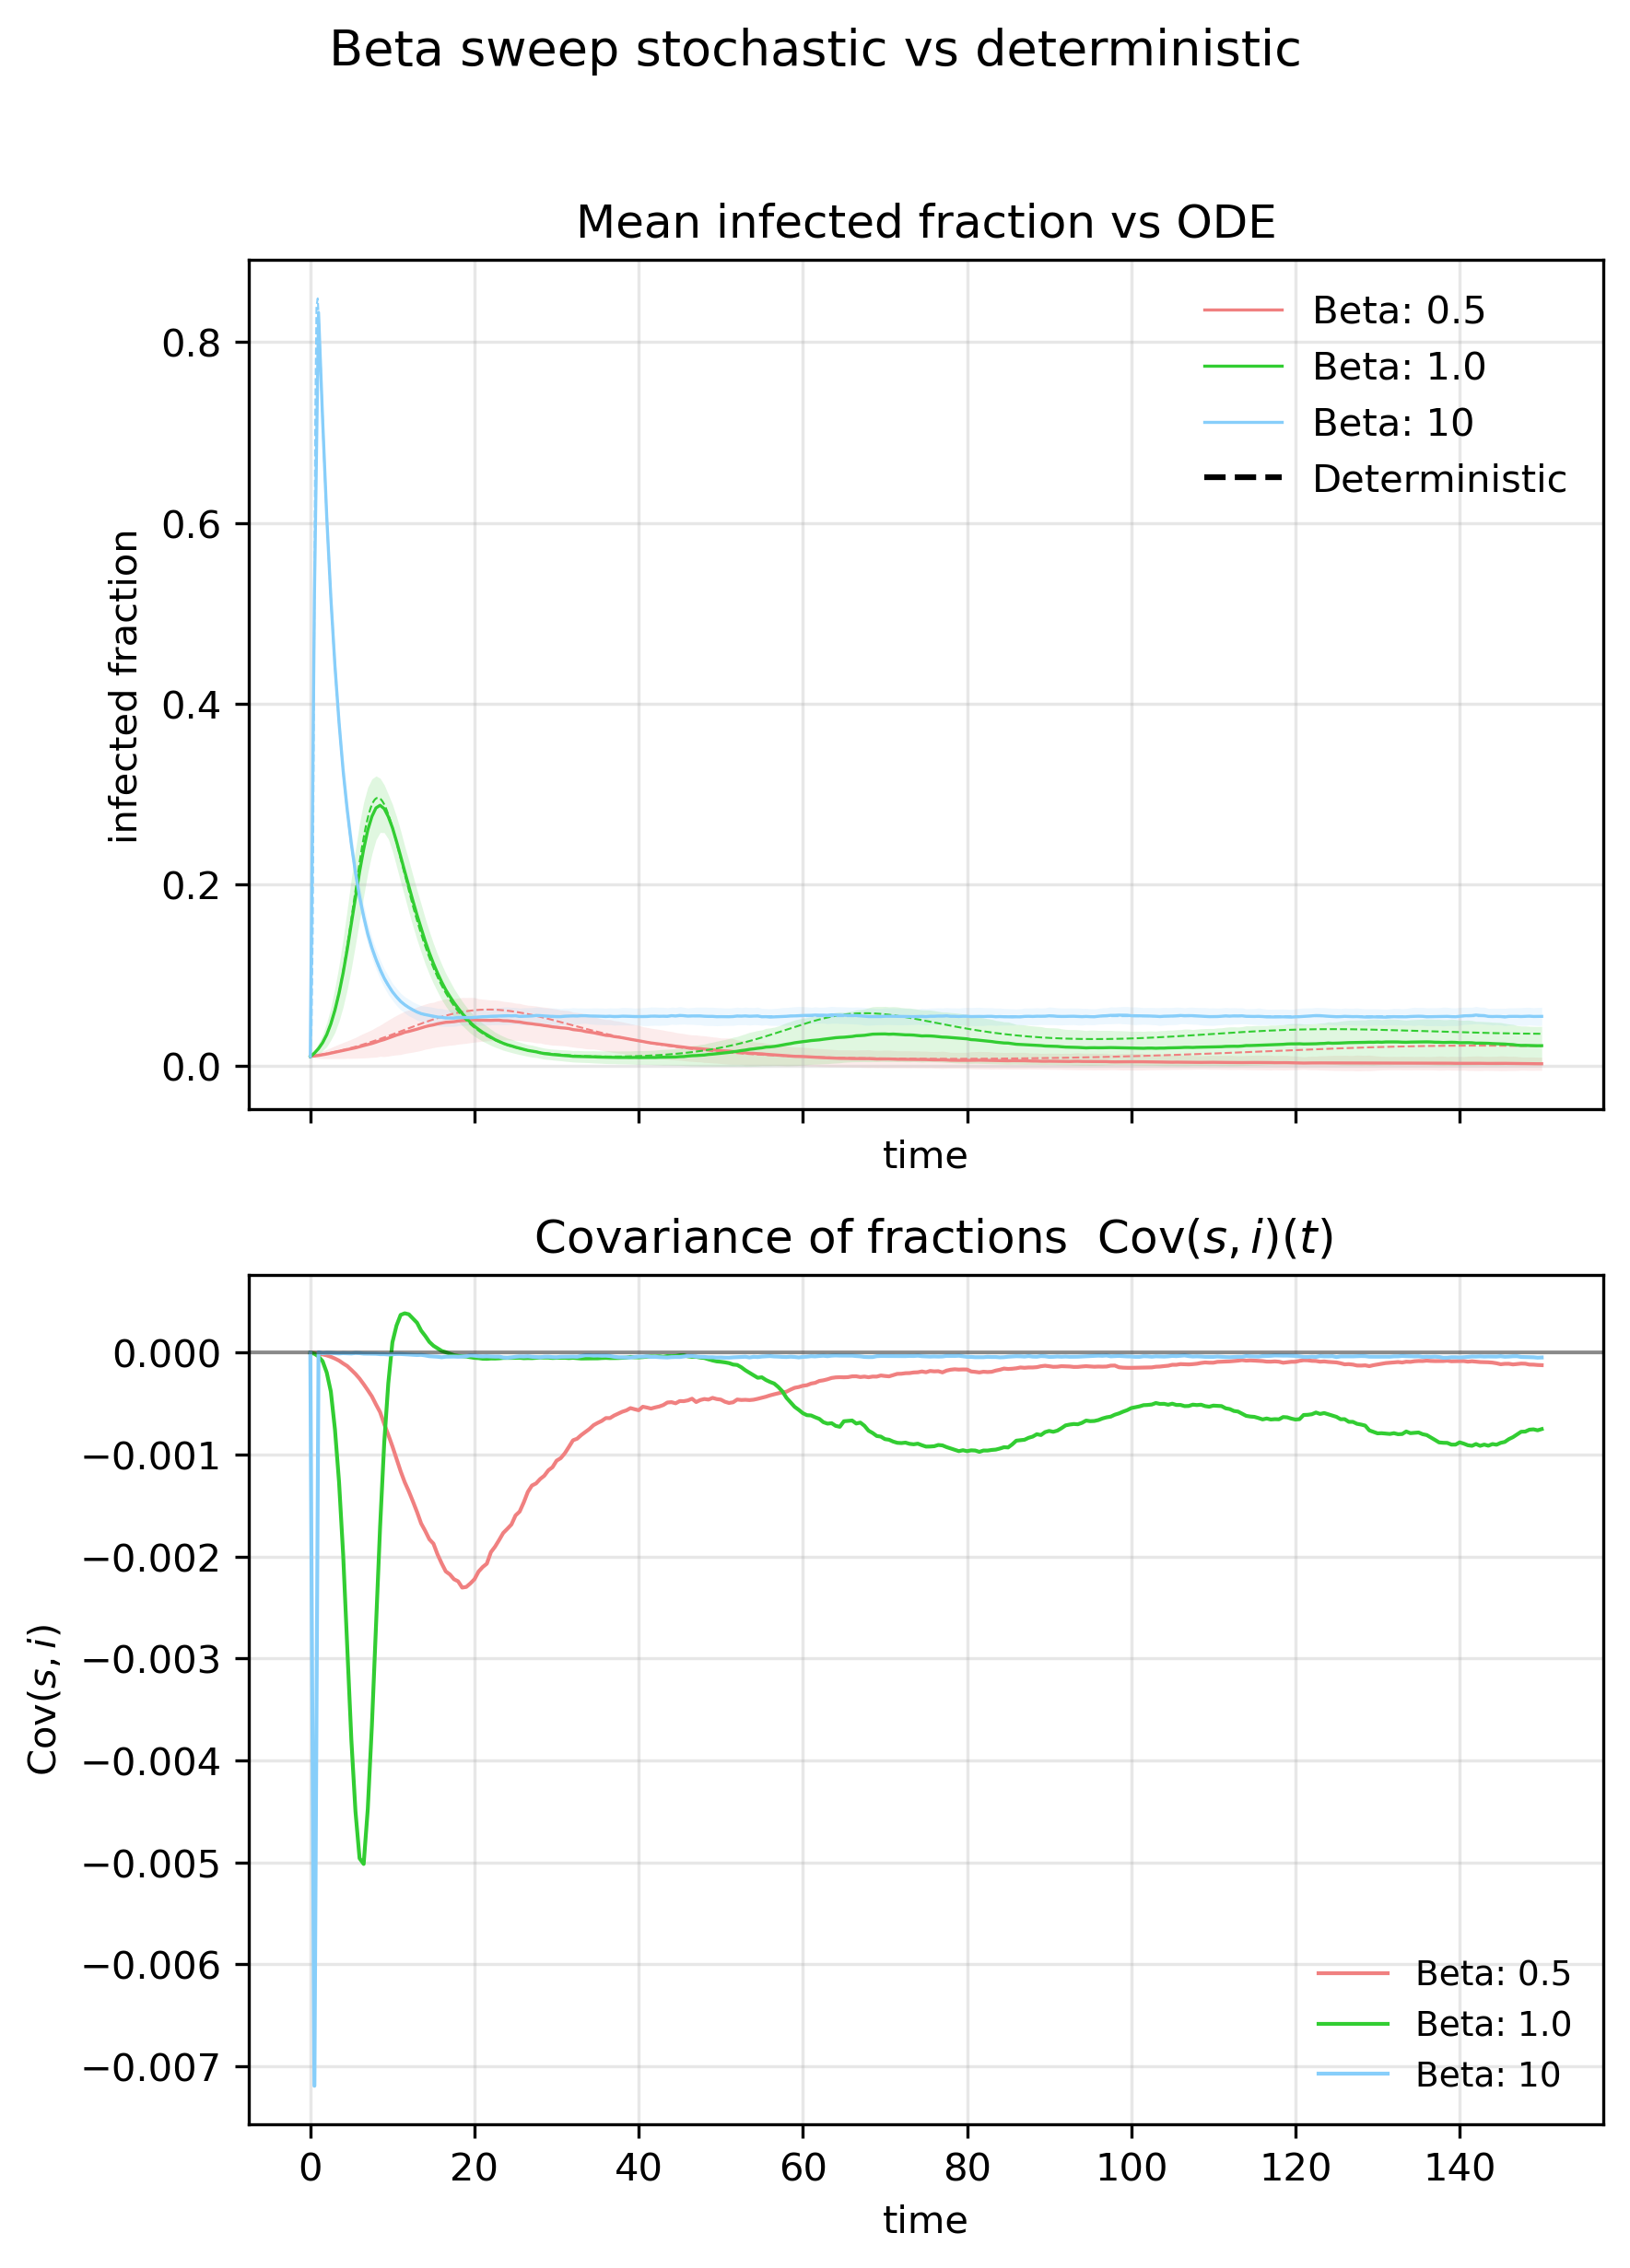

In [56]:
# plot beta sweep results
plot_sweep("Beta", "Beta sweep stochastic vs deterministic", beta_sweep)

(<Figure size 1800x2400 with 2 Axes>,
 array([<Axes: title={'center': 'Mean infected fraction vs ODE'}, xlabel='time', ylabel='infected fraction'>,
        <Axes: title={'center': ' Covariance of fractions  $\\mathrm{Cov}(s,i)(t)$'}, xlabel='time', ylabel='$\\mathrm{Cov}(s,i)$'>],
       dtype=object))

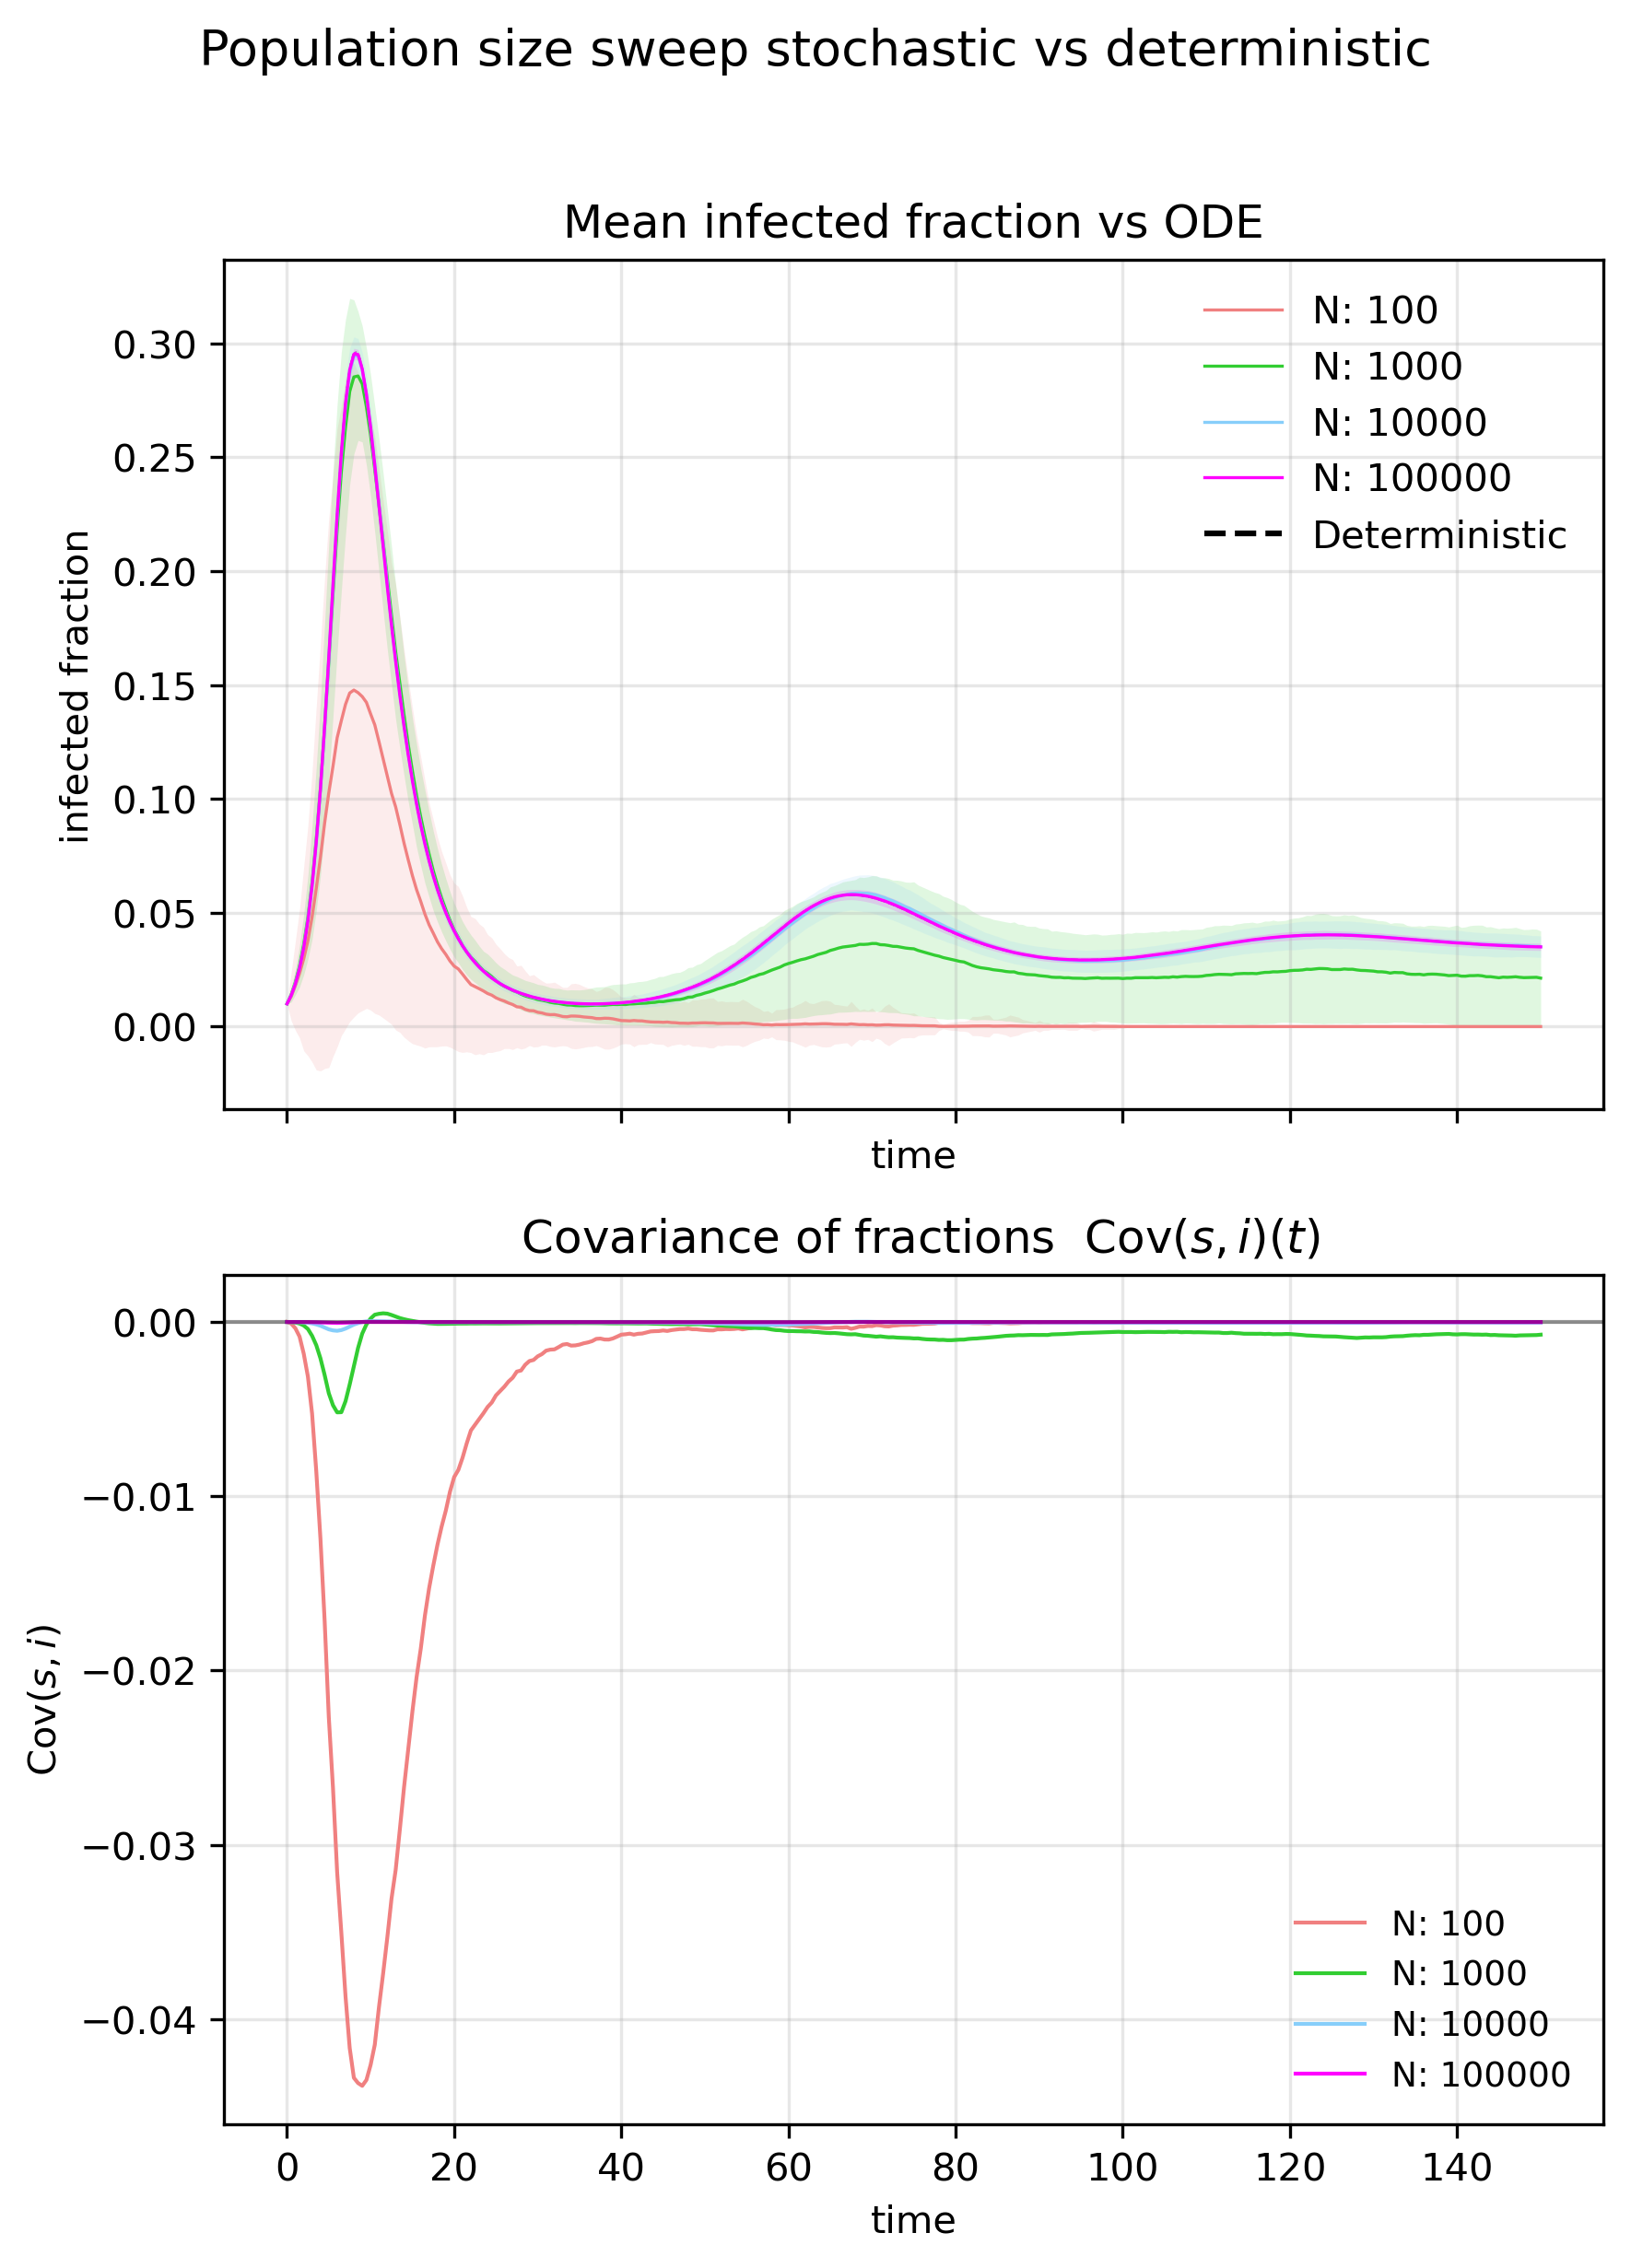

In [57]:
# plot popuklation sweep results
plot_sweep("N", "Population size sweep stochastic vs deterministic", N_sweep)

(<Figure size 1800x2400 with 2 Axes>,
 array([<Axes: title={'center': 'Mean infected fraction vs ODE'}, xlabel='time', ylabel='infected fraction'>,
        <Axes: title={'center': ' Covariance of fractions  $\\mathrm{Cov}(s,i)(t)$'}, xlabel='time', ylabel='$\\mathrm{Cov}(s,i)$'>],
       dtype=object))

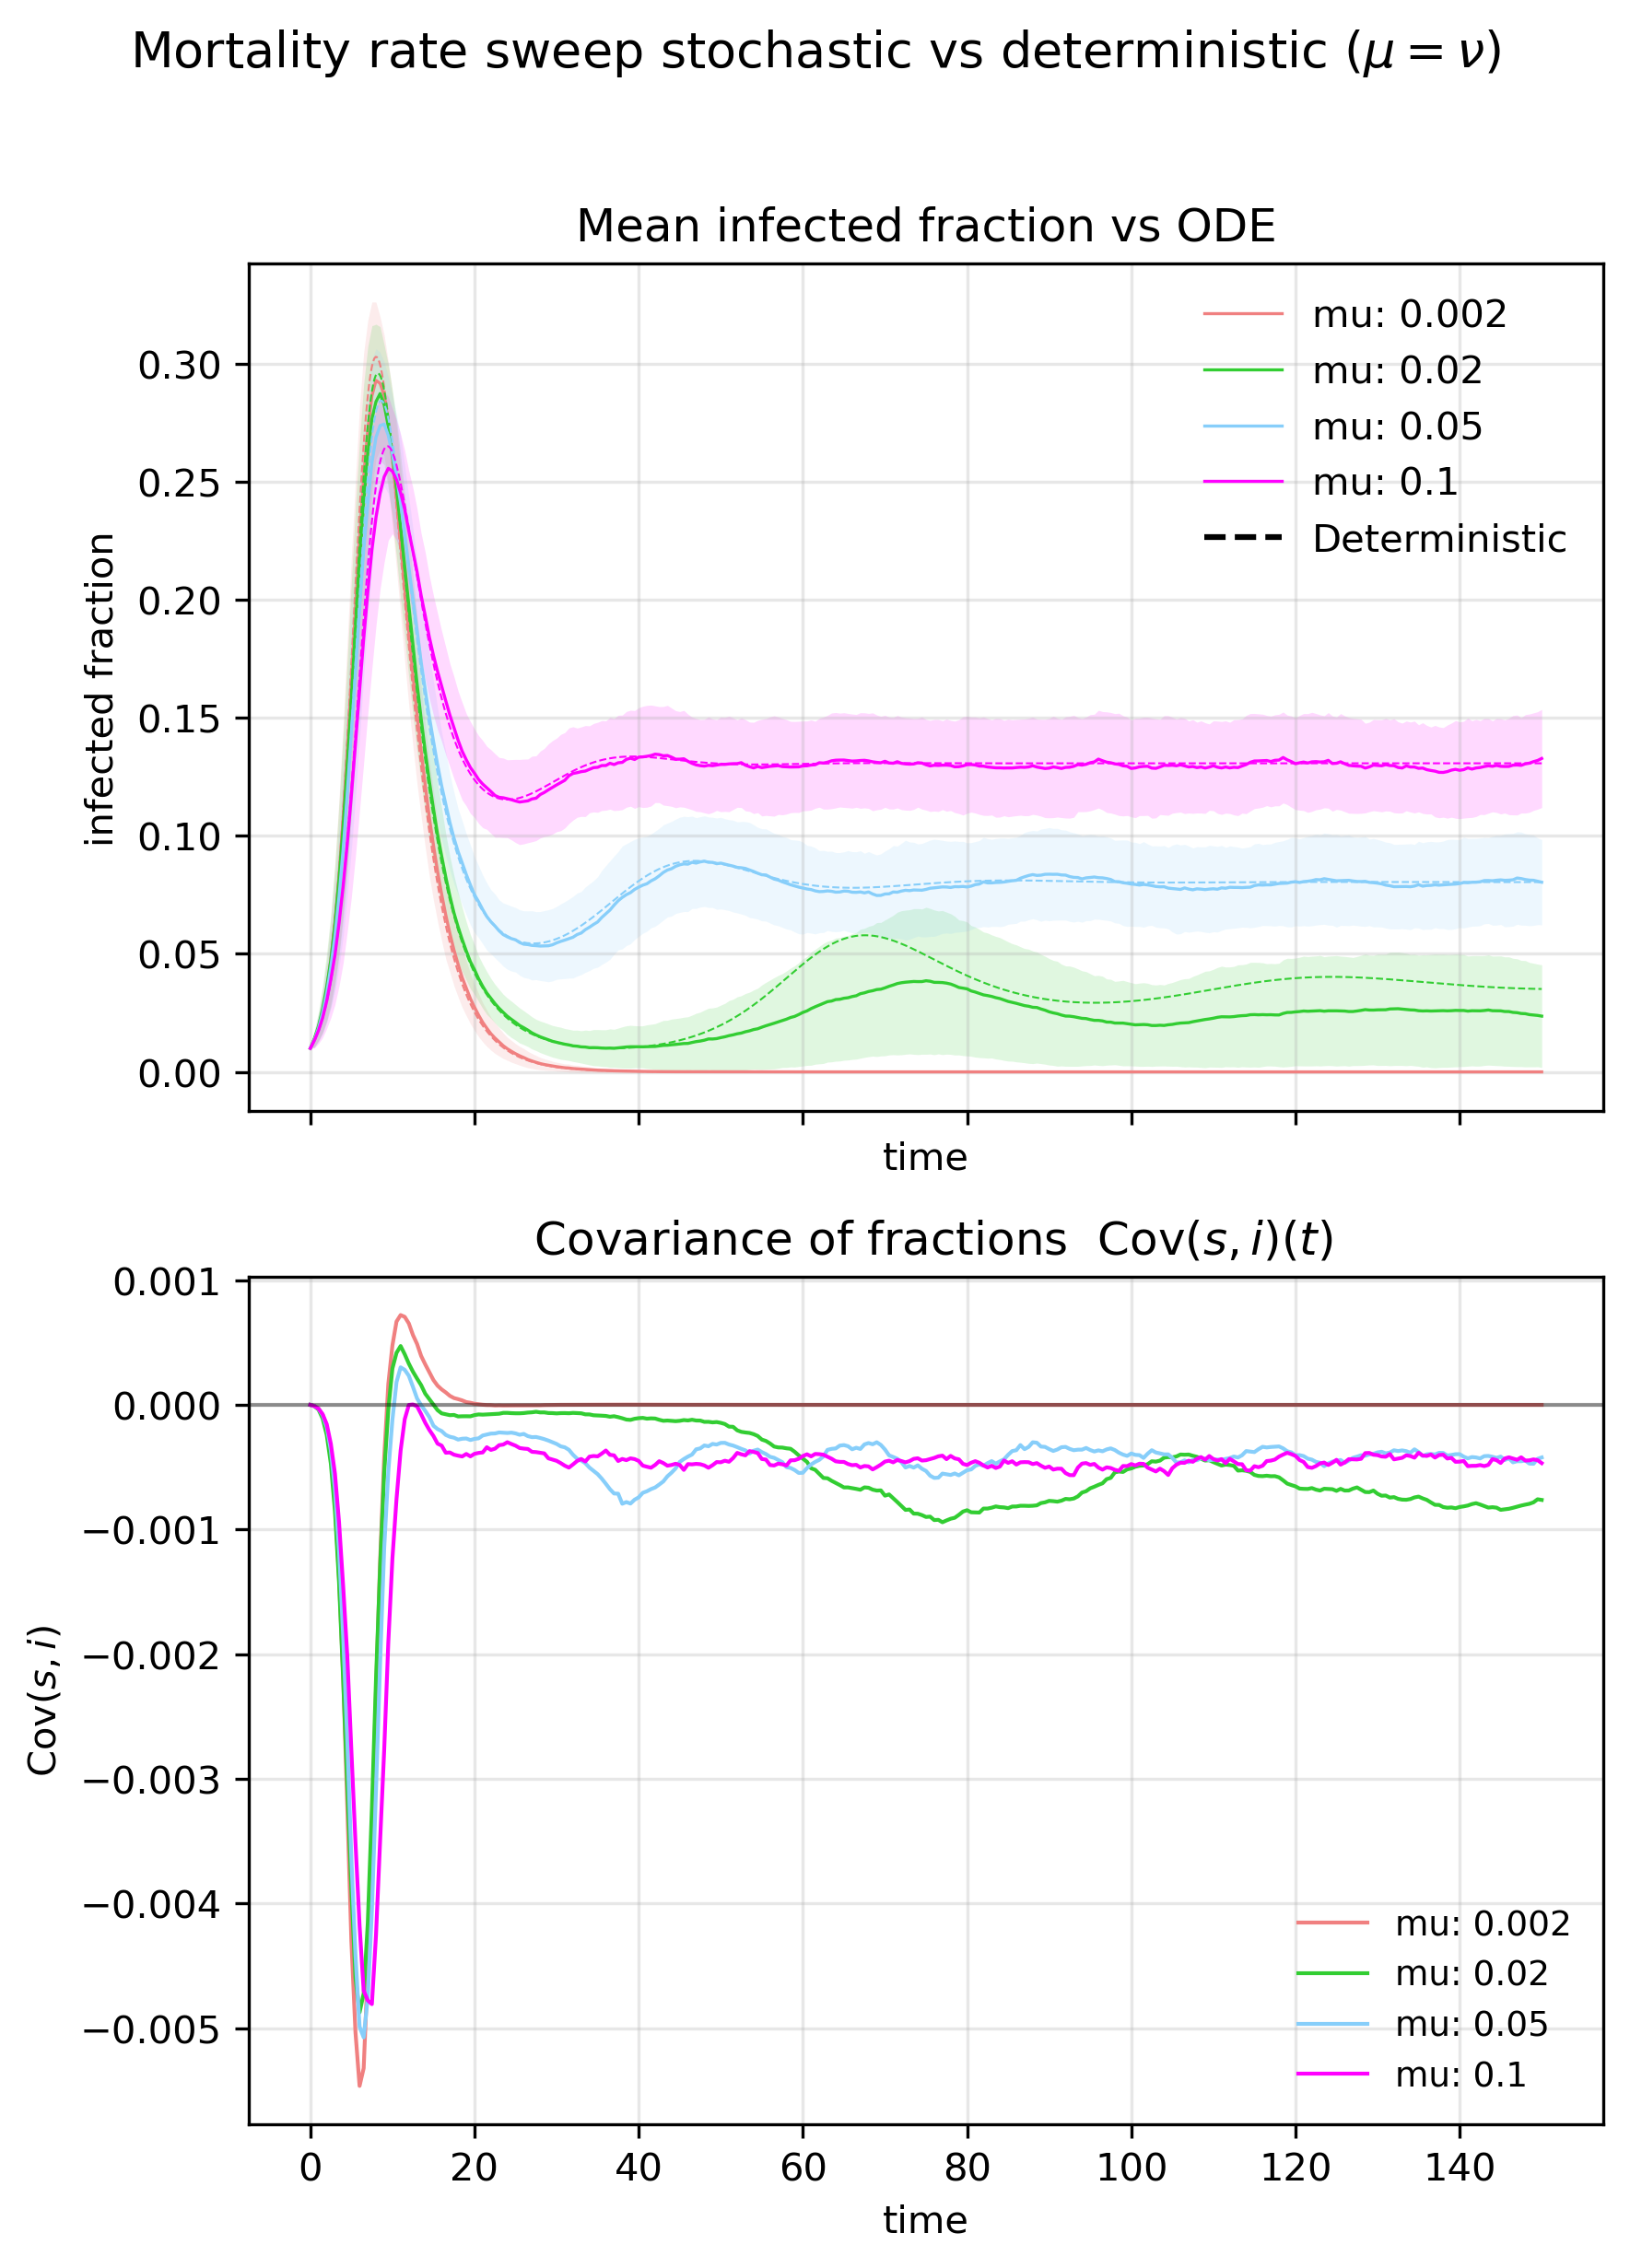

In [58]:
# plot mu sweep results
plot_sweep("mu", r"Mortality rate sweep stochastic vs deterministic ($\mu=\nu$)", mu_sweep)

In [ ]:
beta = 1
gamma = 1 / 3
mu = nu = 1 / 50
R_0 = beta / (mu + gamma)

# if mu << gamma T ~ 2pi*sqrt(AG)
A = 1 / mu * (R_0 - 1)
G = 1 / (mu + gamma)

# calculate natural period
natural_period = 2 * np.pi * np.sqrt(A * G)


In [ ]:
def find_extinction(grid, trajectories, ext_limit=0.01):
    """
    This function analyzes extinction events in Gillespie SIR trajectories.
    
    Parameters:
    grid : common time grid
    trajectories : array of shape (n_runs, len(grid), 3) with X,Y,Z trajectories
    ext_limit : fraction threshold to define extinction (default 0.01)
    
    returns:
    dict with extinction statistics
    """
    
    # extract S, I, R
    X = trajectories[:,:,0]
    Y = trajectories[:,:,1]
    Z = trajectories[:,:,2]
    
    # initial population size per run
    N0 = X[:, 0] + Y[:, 0] + Z[:, 0]

    # Number and probability of early extinction
    ext_mask = Y[:,1:].max(axis=1) <= ext_limit * N0 
    n_ext = np.sum(ext_mask)
    p_early_ext = np.mean(ext_mask)
    
    # Probability extinct by final time T
    extinct_by_T_mask = (Y[:, -1] == 0)
    p_extinct_by_T = extinct_by_T_mask.mean()


    # Fraction of time extinct / infected (per run)
    frac_time_extinct_per_run  = (Y == 0).mean(axis=1)
    mean_frac_time_extinct  = float(frac_time_extinct_per_run.mean())


    # time to first extinction after t>0
    t = np.asarray(grid)
    t_ext = np.full(Y.shape[0], np.inf, dtype=float)
    mask_after0 = (Y[:, 1:] == 0)
    for k in range(Y.shape[0]):
        idx = np.where(mask_after0[k])[0]
        if idx.size:
            t_ext[k] = t[1:][idx[0]]


    return {
        "extinction_count": n_ext, 
        "extinction_probability": p_early_ext,
        "extinct_by_t": p_extinct_by_T,
        "extinction as time fraction": mean_frac_time_extinct,
        "time to first extinction": t_ext
        }



In [ ]:
def extinction_sweep(parameter, values, initial_state, T_max, n_runs, demo_on= False, imp=False):
    """
    This function performs a parameter sweep to analyze extinction events in the Gillespie SIR model.
    
    Parameters:
    parameter : str, the parameter to vary ("beta", "gamma", "mu", "nu", "N", "R0")
    values : list of values for the parameter
    initial_state : tuple (X0, Y0, Z0) initial counts
    T_max : maximum simulation time
    n_runs : number of simulation runs
    demo_on : boolean, if True includes demography
    imp : boolean, if True includes importation of cases
    
    Returns:
    dict mapping each parameter value to extinction statistics and simulation results
    """
   
    results = {}

    # loop over parameter values
    for val in values:
        params = {
        "beta": 1,
        "gamma": 1/3,
        "mu" : 1/50,
        "nu" : 1/50,
        "N" : 1000,
        }

        # set initial state and update parameter
        X, Y, Z = initial_state
        params[parameter] = val

        if parameter == "R0":
            params['beta'] = val * params["gamma"]
        
        if parameter == "N":
            X = val - 1
            Y = 1
        
        #run simulations
        grid, all_traj = run_gillespie(
            initial_state=(X, Y, Z),
            beta=params["beta"],
            gamma=params["gamma"],
            mu=params["mu"],
            nu=params["nu"],
            t_max=T_max,
            n_runs=n_runs,
            demography=False if not demo_on else True,
            imp = True if imp else False
        )
        stats = summary_stats(grid, all_traj)
        ext_stats = find_extinction(grid, all_traj)

        # solve deterministic ODE for comparison
        N = X + Y + Z
        y0 = np.array([X/N, Y/N, Z/N])
        t_ode = np.linspace(0, T_max, 1000)
        solved = odeint(sir_ode_no_demo, y0, t_ode, args=(params["beta"], params["gamma"]))
        S_det, I_det, R_det = solved.T  

        results[val] = {
            "params": params,
            "init_state": (X, Y, Z),
            "grid": grid,                   
            "traj": all_traj,               
            "stats": stats,
            "ext_stats": ext_stats,                 
            "ode_t": t_ode,                 
            "ode_SIR": (S_det, I_det, R_det)  
        }
    return results
        

        


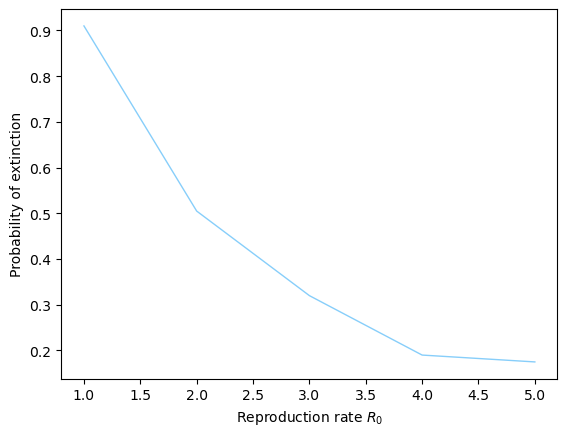

In [ ]:
# perform extinction sweep over R0
R0_sweep = extinction_sweep(
    "R0",
    np.arange(1, 5 + 0.2, 1),
    (999, 1, 0),
    300,
    200,
    )


vals = np.array(list(R0_sweep), dtype=float)
p_ext = np.array([R0_sweep[val]["ext_stats"]["extinction_probability"] for val in vals])

# test plot
plt.figure(figsize=(6,4), dpi=300)
plt.plot(vals, p_ext, lw=1, color="lightskyblue")
plt.title("")
plt.ylabel("Probability of extinction")
plt.xlabel(r"Reproduction rate $R_0$")
plt.show()

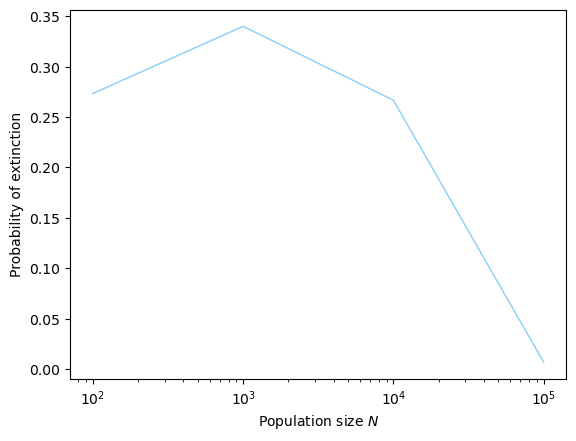

In [ ]:
# perform extinction sweep over N
N_sweep = extinction_sweep(
    "N",
    [100, 1000, 10000, 100000],
    (999, 1, 0),
    300,
    150,
    True,
    True
    )

vals = np.array(list(N_sweep), dtype=float)
p_ext = np.array([N_sweep[val]["ext_stats"]["extinction_probability"] for val in vals])
time_frac_ext = np.array([N_sweep[val]["ext_stats"]["extinction as time fraction"] for val in vals])

# test plot
plt.figure(figsize=(6,4), dpi=300)
plt.plot(vals, p_ext, lw=1, color="lightskyblue")
plt.title("")
plt.ylabel("Probability of extinction")
plt.xlabel(r"Population size $N$")
plt.xscale("log")
plt.show()

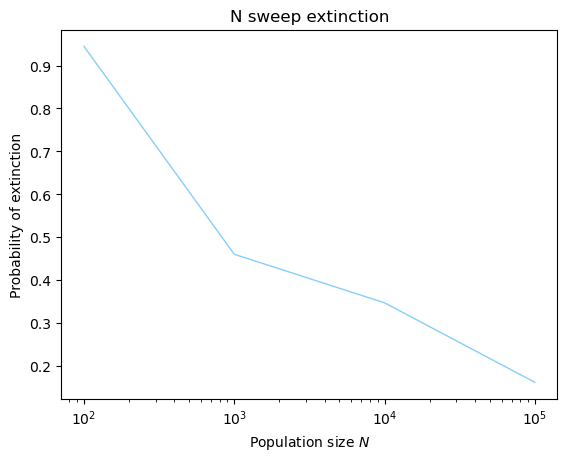

In [ ]:
time_frac_ext = np.array([N_sweep[val]["ext_stats"]["extinction as time fraction"] for val in vals])

# test plot
plt.figure(figsize=(6,4), dpi=300)
plt.plot(vals, time_frac_ext, lw=1, color="lightskyblue")
plt.title("N sweep extinction")
plt.ylabel("Fraction of time extinct")
plt.xlabel(r"Population size $N$")
plt.xscale("log")
plt.show()

In [ ]:
# Create heatmap of extinction as function of R0 and N
R0_list = np.arange(0, 5 + 0.001, 0.2)
N_list = [100, 500, 1000, 5000, 10000, 50000, 100000]

# prepare heatmap array
heatmap = np.zeros((len(R0_list), len(N_list)), dtype=float)

# sweep over R0 and N
for i, R0 in enumerate(R0_list):
    beta = R0 * gamma

    for j, N in enumerate(N_list):
        X0, Y0, Z0 = N - 1, 1, 0
        
        grid, traj = run_gillespie(
            initial_state=(X0, Y0, Z0),
            beta=beta, gamma=gamma,
            mu=1/50, nu=1/50,           
            t_max=T_max, n_runs=300,
            demography=True, imp=True
        )
        ext_dict = find_extinction(grid, traj)
        heatmap[i, j] = ext_dict["extinction as time fraction"]

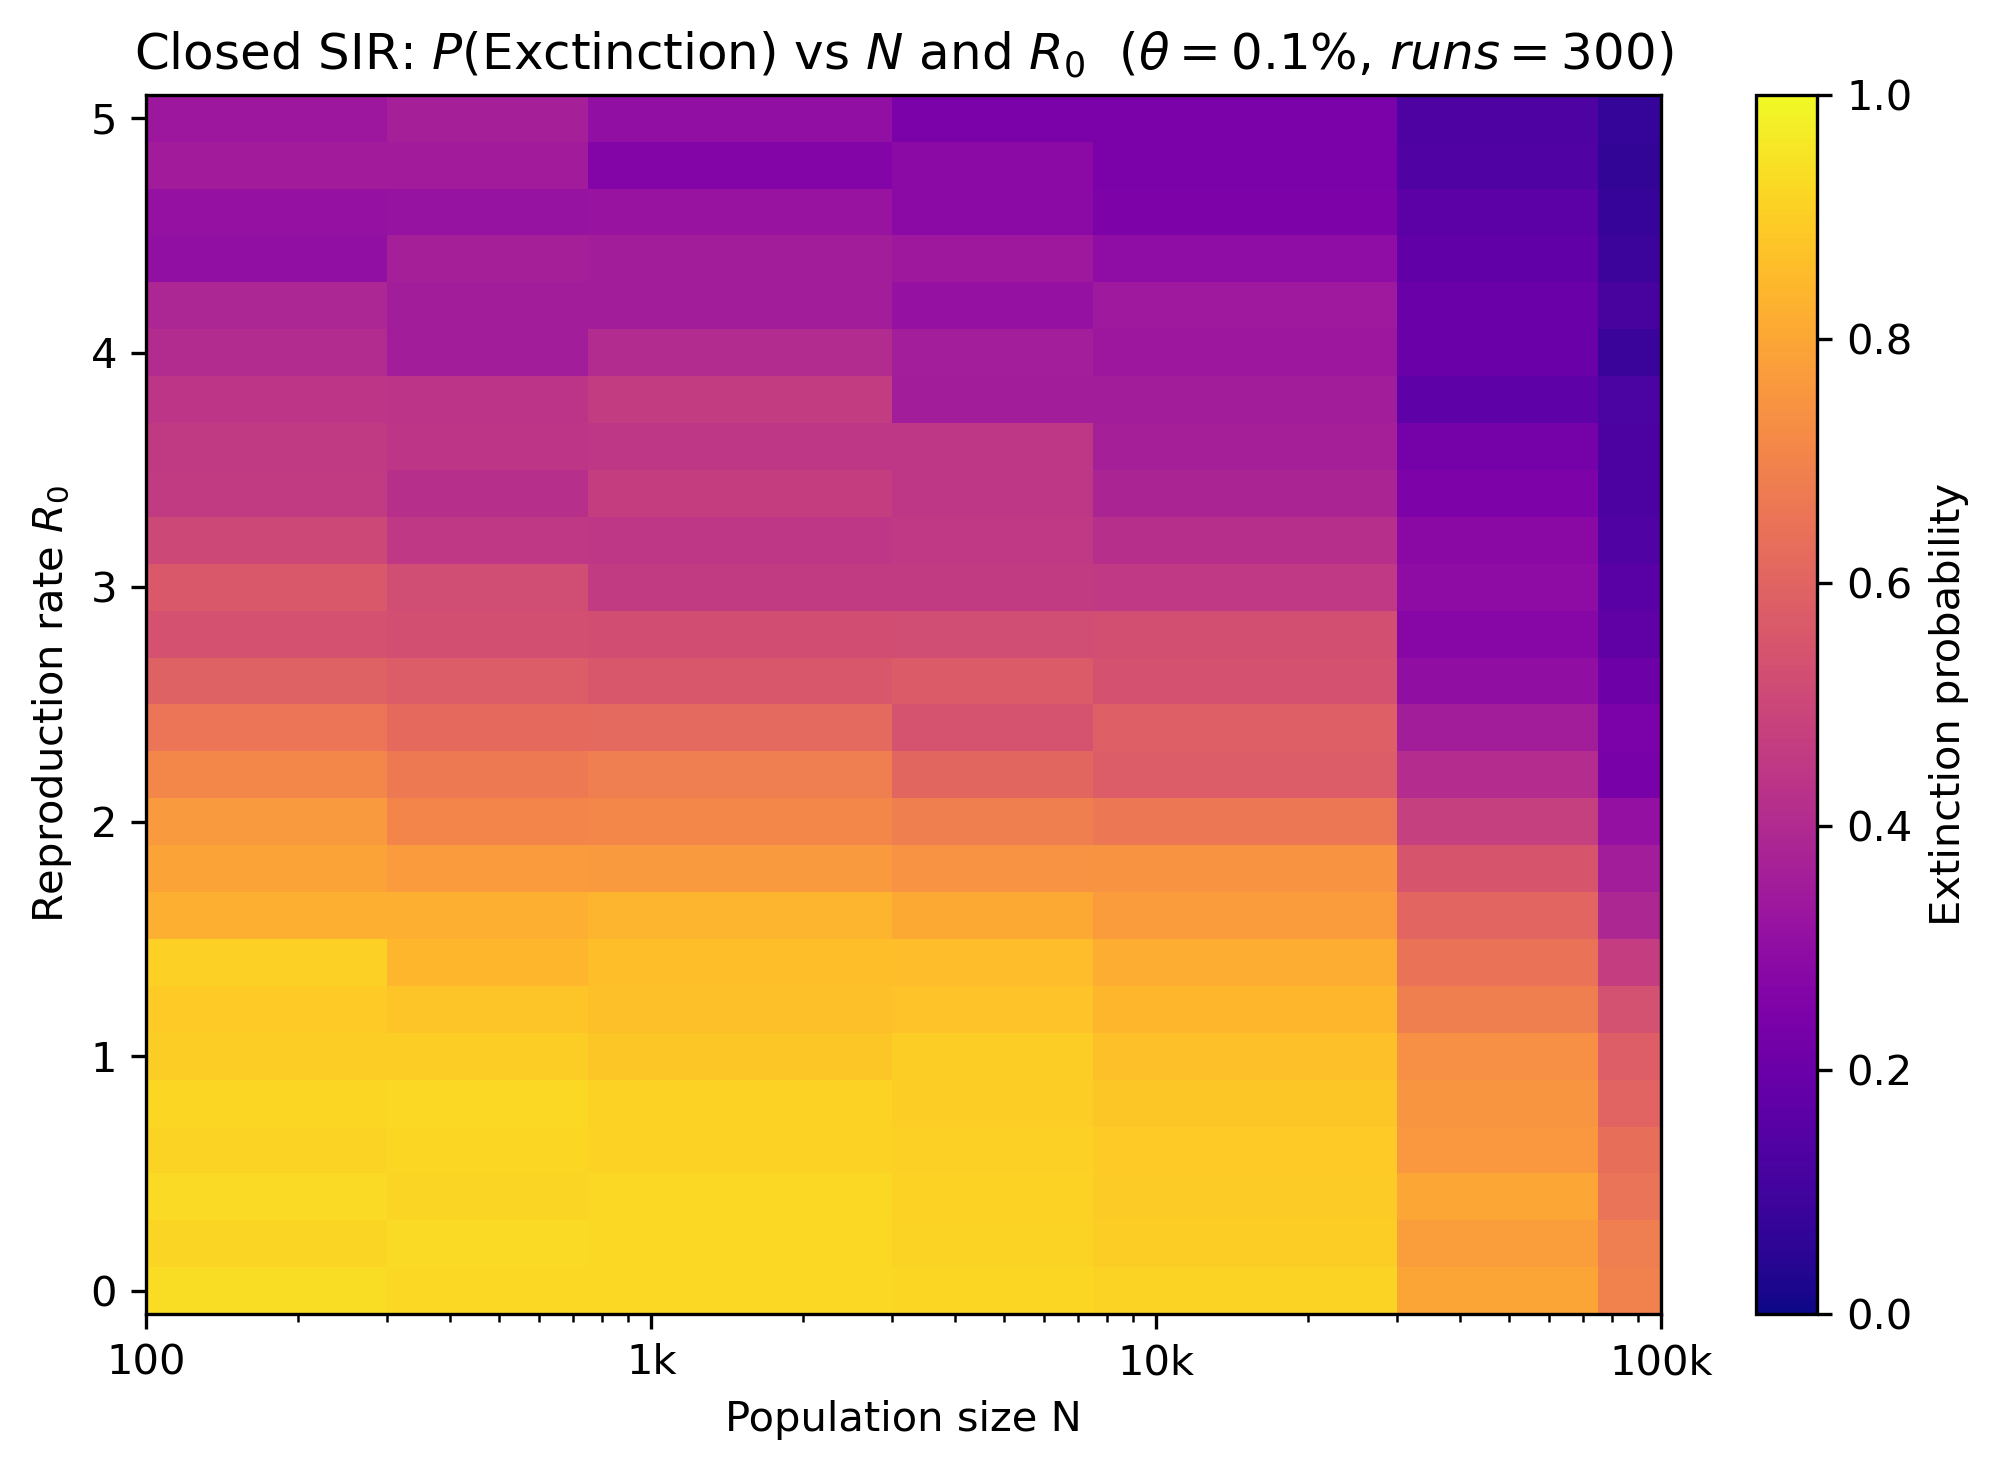

In [ ]:
# heatmap plot using pcolormesh
plt.figure(figsize=(7,5), dpi=300)

R0R0, NN = np.meshgrid(R0_list, N_list, indexing='ij')
pcm = plt.pcolormesh(NN, R0R0, heatmap, shading='auto', vmin=0, vmax=1, cmap='plasma')
plt.colorbar(pcm, label='Extinction probability')
plt.xlabel('Population size N')
plt.ylabel('Reproduction rate $R_0$')
plt.title(rf'Closed SIR: $P(\mathrm{{Exctinction}})$ vs $N$ and $R_0$  ($\theta={0.1}\%$, $runs=300$)')
plt.xlim(min(N_list), max(N_list))
plt.xscale("log")
plt.xticks([100, 1_000, 10_000, 100_000],
           ['100', '1k', '10k', '100k'])
plt.tight_layout()
plt.show()

In [45]:
edges = [min(N_list), max(N_list), min(R0_list), max(R0_list)]

# heatmap plot using imshow
plt.figure(figsize=(7,5), dpi=300)
img = plt.imshow(
    heatmap, origin="lower", aspect="auto",
    extent=edges, vmin=0, vmax=1, cmap="plasma"
)
plt.xscale('log')                                
plt.colorbar(img, label='Extinction probability')
plt.xlabel('Population size N')
plt.ylabel(r'Reproduction rate $R_0$')

plt.title(r'Closed SIR: $P(\mathrm{Extinction})$ vs $N$ and $R_0$')
plt.tight_layout()
plt.show()

NameError: name 'N_list' is not defined

In [21]:
# Network-based SIR model using NDLib
# create Erdős-Rényi graph
ER = nx.erdos_renyi_graph(1000, 0.1)

# configure SIR model
sir_er = ep.SIRModel(ER)
config = mc.Configuration()
config.add_model_parameter("beta", 1)
config.add_model_parameter('gamma', 1/3)
config.add_model_parameter("fraction_infected", 0.01)
sir_er.set_initial_status(config)



In [22]:
# Simulate and build trends
iterations = sir_er.iteration_bunch(500)
trends = sir_er.build_trends(iterations)
print(trends)

[{'trends': {'node_count': {0: [990, 368, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [23]:
# Visualize diffusion trend - test plot
# viz = DiffusionTrend(sir_er, trends)
# p = viz.plot("Diffusion plot sir test")


In [24]:
def get_net_parameters(k, n):
    """
    Calculate equivalent network parameters for different graph models.
    
    Parameters:
    k : average degree
    n : number of nodes
    
    Returns:
    ED_p : probability for Erdős-Rényi graph
    BA_m : number of edges to attach for Barabási-Albert graph
    WS_k : neighborhood size for Watts-Strogatz graph
    """
    ED_p = k / (n-1)
    BA_m = int(k / 2)
    WS_k = k
    return ED_p, BA_m, WS_k
    
    

In [ ]:
ED_p, BA_m, WS_k = get_net_parameters(30, 1000)
BA = nx.barabasi_albert_graph(1000, BA_m)

sir_ba = ep.SIRModel(BA)
sir_ba.set_initial_status(config)

iterations = sir_ba.iteration_bunch(500)
trends = sir_ba.build_trends(iterations)
print(trends)
# viz = DiffusionTrend(sir_er, trends)
# p = viz.plot("Diffusion plot sir test Barabasi Albert")


[{'trends': {'node_count': {0: [990, 756, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

<Figure size 2000x1000 with 0 Axes>

In [13]:
WS = nx.watts_strogatz_graph(1000, WS_k, 0.2)
sir_ws = ep.SIRModel(BA)
sir_ws.set_initial_status(config)

iterations = sir_ws.iteration_bunch(500)
trends = sir_ws.build_trends(iterations)
# viz = DiffusionTrend(sir_ed, trends)
# p = viz.plot("Diffusion plot sir test Barabasi Albert")

In [30]:
def simulate_sir_on_network_batch(graph_type, param, n_nodes, beta, gamma, initial_infected_frac, n_runs, n_steps):
    """
    Simulate SIR model on different network types in batch.
    
    Parameters:
    graph_type : str, type of graph ("ER", "BA", "WS")
    param : parameter for the graph (p for ER, m for BA, k for WS)
    n_nodes : number of nodes in the graph
    beta : infection rate
    gamma : recovery rate
    initial_infected_frac : initial fraction of infected nodes
    n_runs : number of simulation runs
    n_steps : number of steps per simulation
    
    Returns:
    list of trends from each simulation run
    """
    trends_list = []
    
    for i in range(n_runs):
        if graph_type == "ER":
            G = nx.erdos_renyi_graph(n_nodes, param)
        elif graph_type == "BA":
            G = nx.barabasi_albert_graph(n_nodes, param)
        elif graph_type == "WS":
            G = nx.watts_strogatz_graph(n_nodes, param, 0.2)
        
        sir_model = ep.SIRModel(G)
        config = mc.Configuration()
        config.add_model_parameter("beta", beta)
        config.add_model_parameter('gamma', gamma)
        config.add_model_parameter("fraction_infected", initial_infected_frac)
        sir_model.set_initial_status(config)
        
        iterations = sir_model.iteration_bunch(n_steps)
        trends = sir_model.build_trends(iterations)
        trends_list.append(trends)
    
    return trends_list

[0, 2, 5, 7, 16, 44, 63, 100, 98, 137, 119, 119, 90, 65, 53, 32, 19, 9, 10, 7, 4, 0, 0, 0, 1]


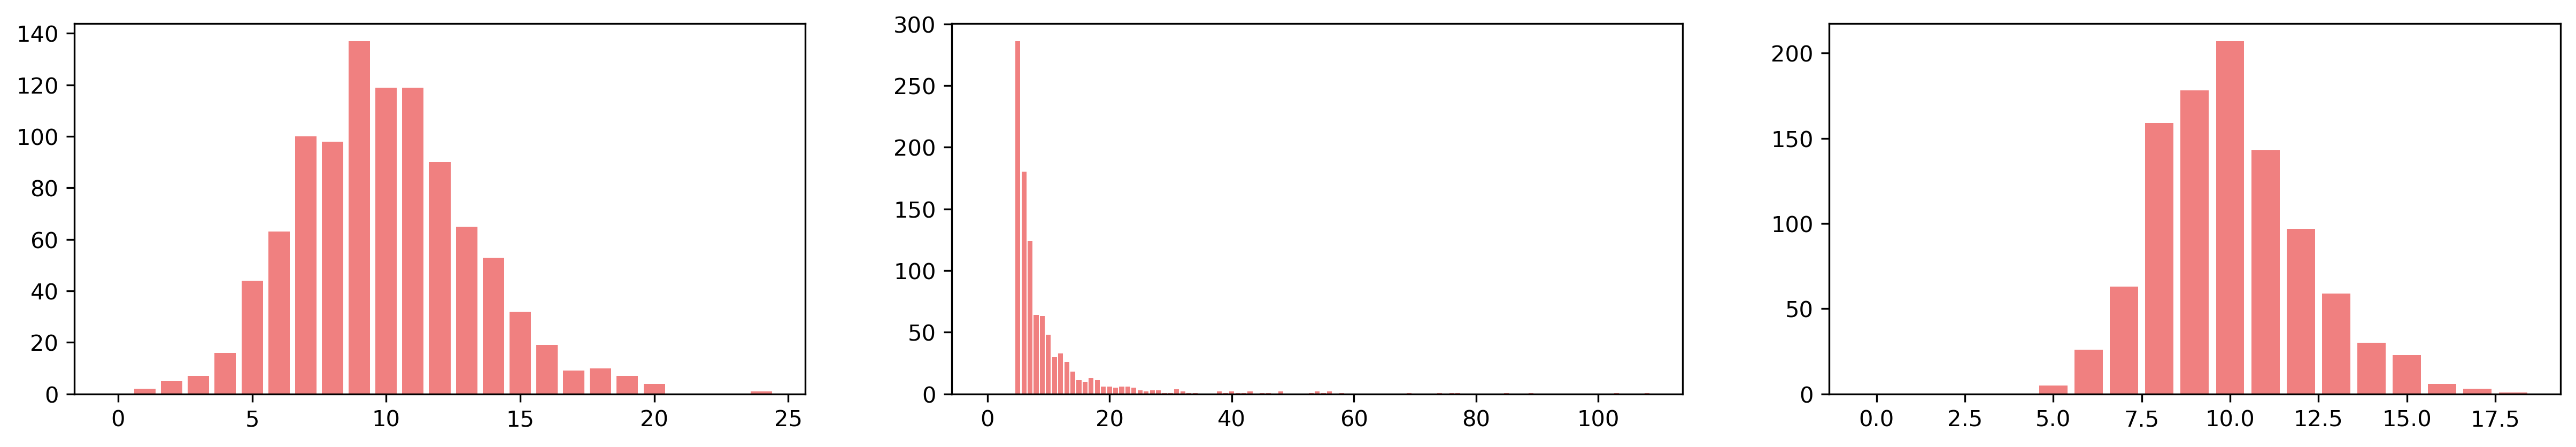

In [31]:
# get degree distributions
er_distribution = nx.degree_histogram(ER)
ba_distribution = nx.degree_histogram(BA)
ws_distribution = nx.degree_histogram(WS)

print(er_distribution)

# make arrays for k values
er_k = np.arange(len(er_distribution))
ba_k = np.arange(len(ba_distribution))
ws_k = np.arange(len(ws_distribution))

# test plot degree distributions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3), dpi=300)

ax1.bar(er_k, er_distribution, color="lightcoral")

ax2.bar(ba_k, ba_distribution, color="lightcoral")

ax3.bar(ws_k, ws_distribution, color="lightcoral")

plt.show()


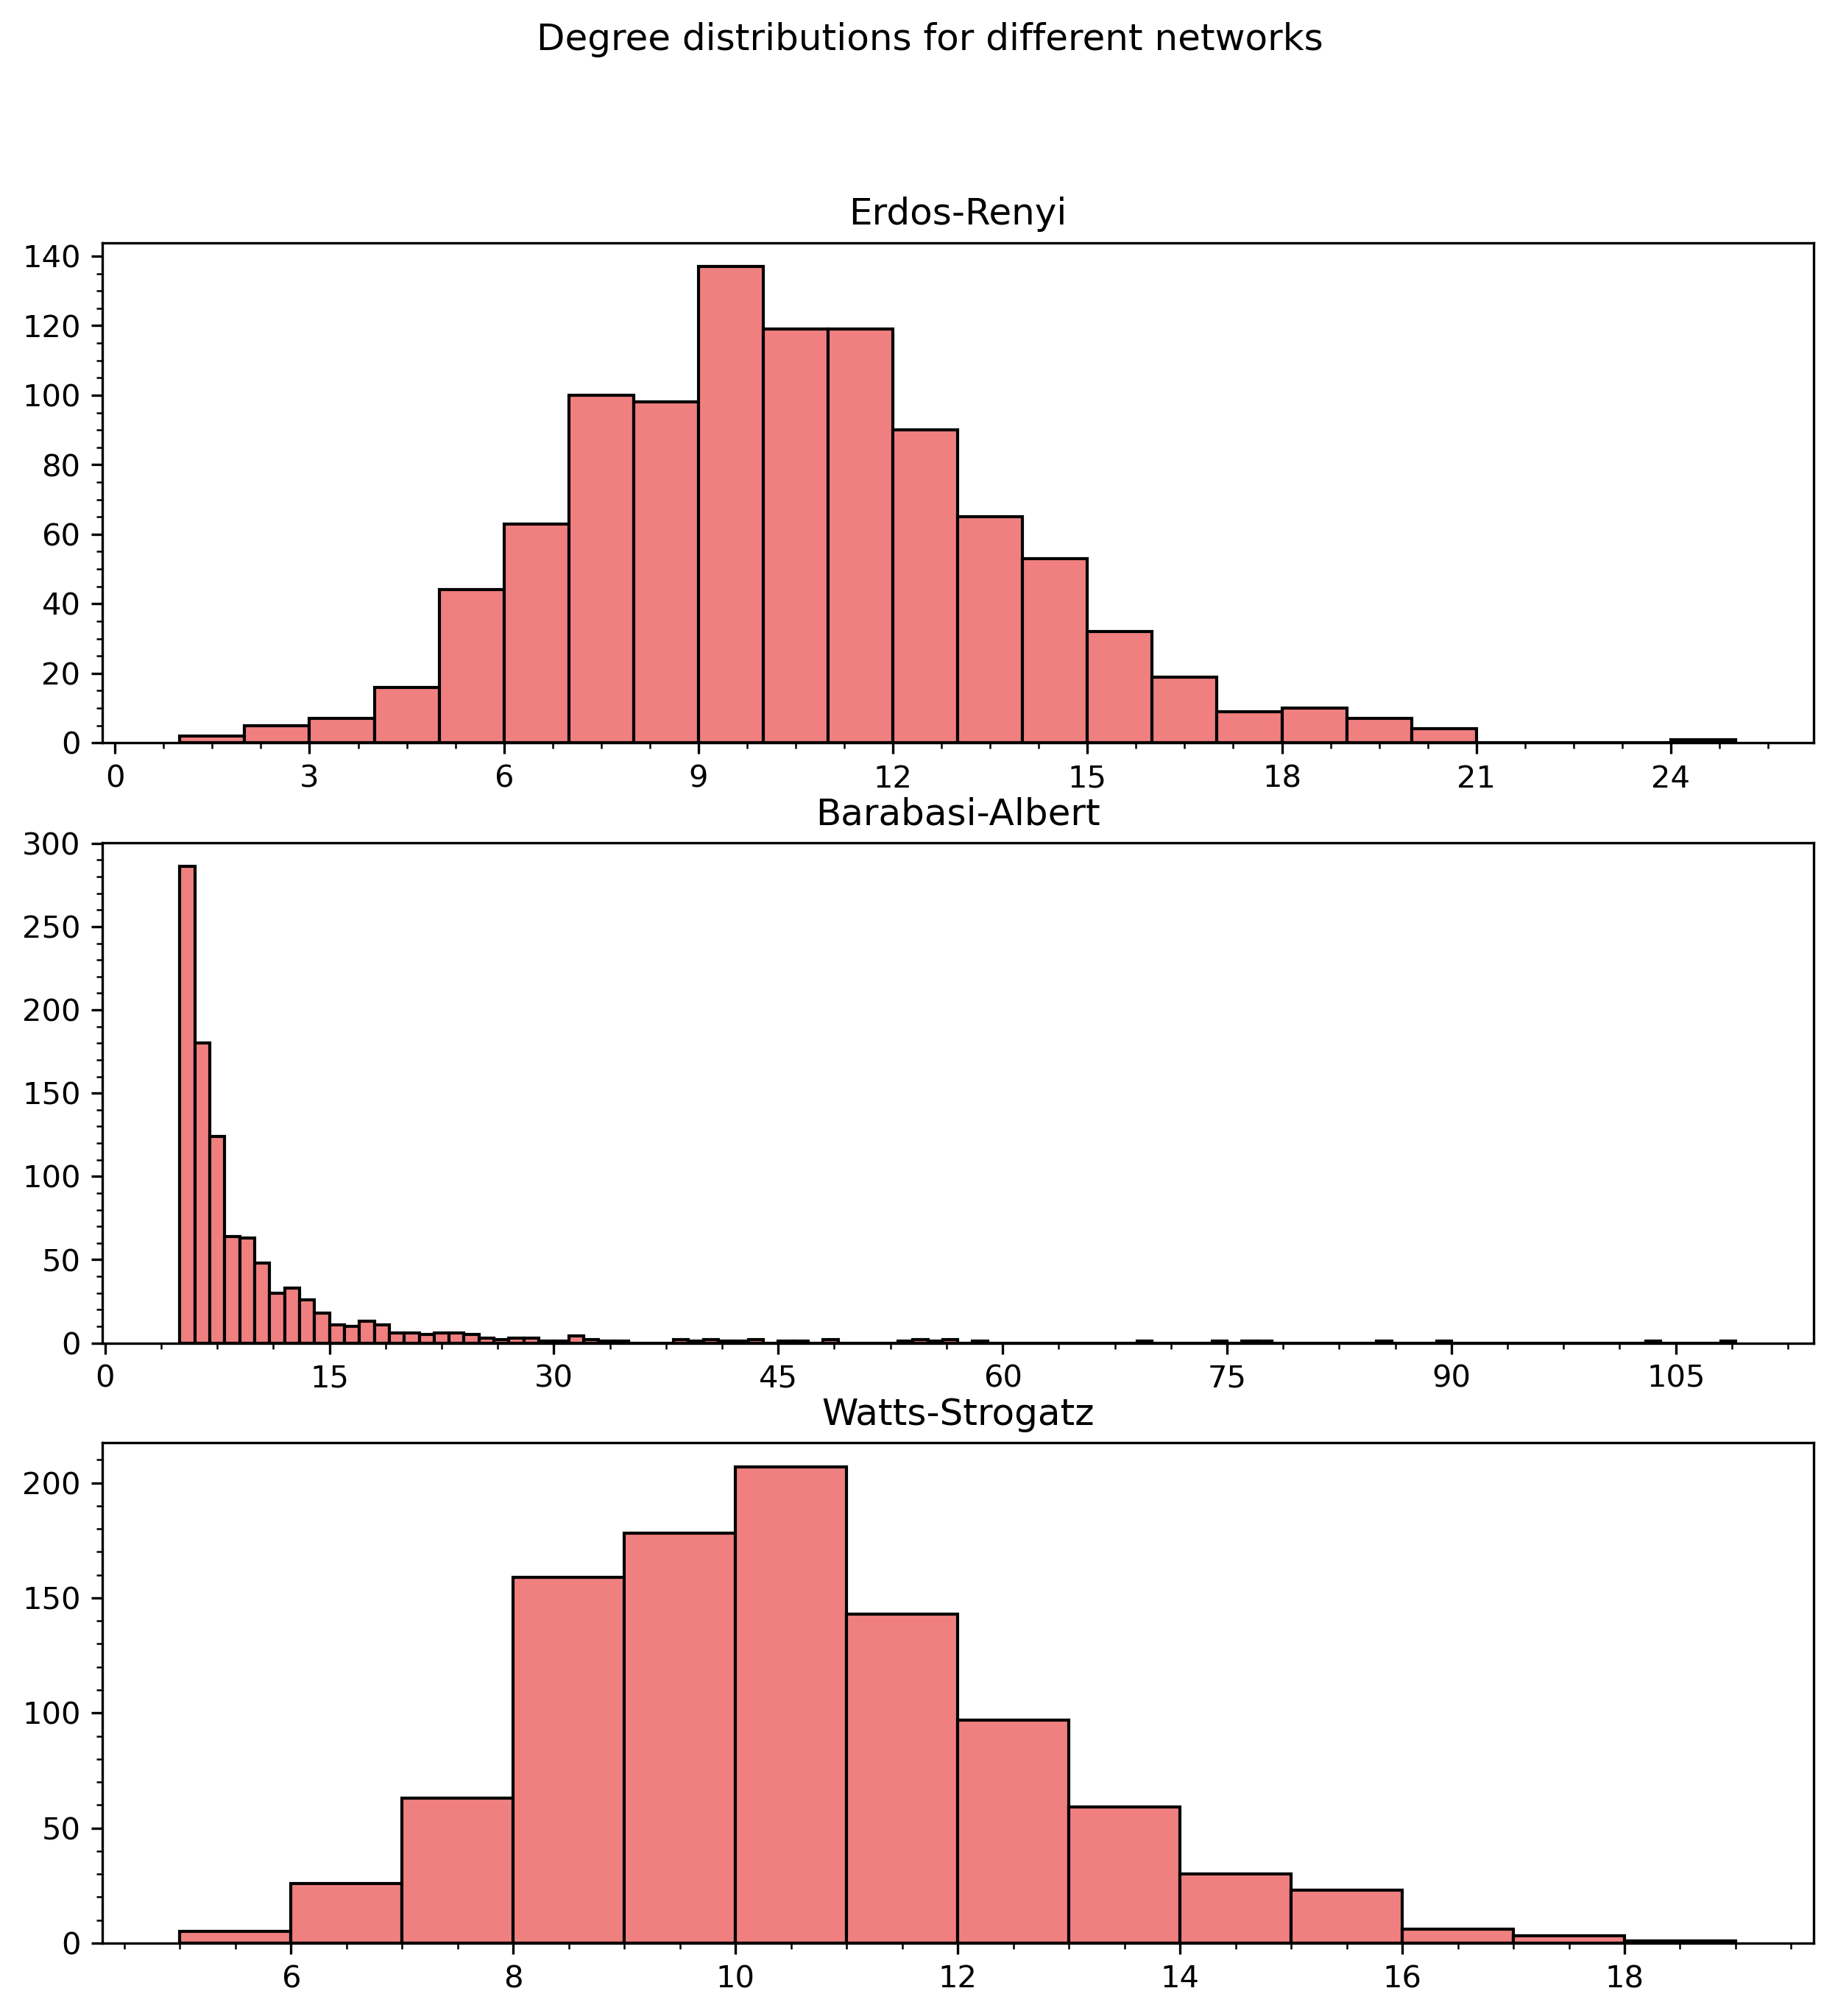

In [32]:
# Plot degree distributions for all three networks
networks = (ER, BA, WS)
network_names = ['Erdos-Renyi', "Barabasi-Albert", 'Watts-Strogatz']
fig, axes = plt.subplots(3, 1, figsize=(10,10), dpi=300)
fig.suptitle('Degree distributions for different networks')

# plot degree histograms
for i, network in enumerate(networks):
    distribution = nx.degree_histogram(network)
    k_list = np.arange(len(distribution))
    first_index = np.flatnonzero(distribution)[0]
    axes[i].bar(k_list[first_index:], distribution[first_index:], color='lightcoral', align='edge', edgecolor='black', width=1)
    
    # make it so that x-axis has integer ticks only
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[i].set_title(network_names[i])
    axes[i].minorticks_on()



In [33]:
def gcc(G):
    """
    Return the giant connected component of graph G.
    
    Parameters:
    G : networkx Graph object
     
    Returns:
    G_sub : subgraph of G corresponding to its giant connected component
    """
    comp = max(nx.connected_components(G), key=len)
    return G.subgraph(comp).copy()


In [21]:
def analyze_graphs(k, n, n_replicates):
    """
    Analyze centrality measures on different network types.
    Parameters:
    k : average degree
    n : number of nodes
    n_replicates : number of replicates per network type
    
    Returns:
    None (Plots centrality measures)
    """
    
    ed_p, ba_m, ws_k = get_net_parameters(k, n)
    
    #centrality measures storage
    bc_vals = {'ER': [], 'BA': [], 'WS': []}      # betweenness
    cc_vals = {'ER': [], 'BA': [], 'WS': []}      # closeness
    asp_vals = {'ER': [], 'BA': [], 'WS': []}     # average shortest path
    
    # loop over replicates
    for i in range(n_replicates):
        ER = nx.erdos_renyi_graph(n, ed_p, seed=i)
        BA = nx.barabasi_albert_graph(n, ba_m, seed=i)
        WS = nx.watts_strogatz_graph(n, k, 0.6, seed=i)
        
        networks = [(ER, 'ER'), (BA, "BA"), (WS, "WS")]
        
        for network, name in networks:
            GC = gcc(network)
            
            # betweenness (normalized)
            bc = nx.betweenness_centrality(GC, seed=i, normalized=True)
            bc_arr = np.fromiter(bc.values(), float)

            # closeness (normalized)
            cc = nx.closeness_centrality(GC)
            cc_arr = np.fromiter(cc.values(), float)

            # average shortest path on GCC
            asp = nx.average_shortest_path_length(GC)

            bc_vals[name].append(bc_arr)
            cc_vals[name].append(cc_arr)
            asp_vals[name].append(asp)
        
        # small constant to avoid log(0)
        eps = 1e-10 
        
        plot_dict = {
            'betweenness': {
            'ER': np.log10(np.concatenate(bc_vals['ER']) + eps),
            'BA': np.log10(np.concatenate(bc_vals['BA']) + eps),
            'WS': np.log10(np.concatenate(bc_vals['WS']) + eps),
            },
            'closeness': {
                'ER': np.concatenate(cc_vals['ER']),
                'BA': np.concatenate(cc_vals['BA']),
                'WS': np.concatenate(cc_vals['WS']),
            },
            'asp': {
                'ER': np.array(asp_vals['ER'], float),
                'BA': np.array(asp_vals['BA'], float),
                'WS': np.array(asp_vals['WS'], float),
            }
        }
    
    fig, axes = plt.subplots(3, 1, dpi=300, figsize=(8, 10))
    fig.suptitle('Centrality measures for different networks')
    
    # plot betweenness
    betweenness_data = [plot_dict['betweenness'][name] for name in ['ER', 'BA', 'WS']]
    axes[0].violinplot(betweenness_data, showmeans=True)
    axes[0].set_xticks([1,2,3], plot_dict['betweenness'].keys())
    axes[0].set_ylabel(r'$\log_{10}(\mathrm{betweenness}+\varepsilon)$')
    axes[0].set_title('Betweenness centrality (pooled across replicates)')
    axes[0].minorticks_on()
    
    # plot closeness
    closeness_data = [plot_dict['closeness'][name] for name in ['ER', 'BA', 'WS']]
    axes[1].violinplot(closeness_data, showmeans=True)
    axes[1].set_xticks([1,2,3], plot_dict['closeness'].keys())
    axes[1].set_ylabel('closeness')
    axes[1].set_title('Closeness centrality (pooled across replicates)')
    axes[1].minorticks_on()
    
    # plot average shortest path  
    asp_data = [plot_dict['asp'][name] for name in ['ER', 'BA', 'WS']]
    axes[2].boxplot(asp_data, labels=plot_dict['asp'].keys())
    axes[2].set_ylabel('average shortest path length (GCC)')
    axes[2].set_title('Avg shortest path across replicates')
    axes[2].minorticks_on()
        
    return


In [22]:
analyze_graphs(5, 1000, 20)

/var/folders/m_/kmm03m750bg3pdtq9z6nsgt00000gn/T/ipykernel_98979/348220611.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(asp_data, labels=plot_dict['asp'].keys())


In [27]:
def run_network(network, beta, gamma, T, initial_infections):
    """
    Run SIR model on a given network using NDLib.
    
    Parameters:
    network : networkx Graph object
    beta : infection rate
    gamma : recovery rate
    T : number of time steps
    initial_infections : list of initially infected nodes
    
    Returns:
    trends : trends dictionary from NDLib
    """
    # do not know what rng ndlib uses
    random.seed(1)
    np.random.seed(1)
    
    # configure and run SIR model
    model = ep.SIRModel(network)
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_initial_configuration("Infected", initial_infections)
    
    model.set_initial_status(config)
    trajectory = model.iteration_bunch(T)
    trends = model.build_trends(trajectory)
    return trends

def top_degree_nodes(network):
    """
    Get nodes sorted by degree in descending order.
    
    Parameters:
    network : networkx Graph object
    
    Returns:
    list of nodes sorted by degree (highest first)
    """
    
    return [n for n, degree in sorted(network.degree(), key=lambda x: (x[1], x[0]), reverse=True)]


def random_k_nodes(network, Y, seed):
    """
    Select Y random nodes from the network.
    
    Parameters:
    network : networkx Graph object
    Y : number of nodes to select
    seed : random seed for reproducibility
    
    Returns:
    list of Y randomly selected nodes
    """
    rng = random.Random(seed)               
    return rng.sample(list(network.nodes()), Y)
    

def beta_sweep_(network, beta_array, gamma, R, Y, T):
    """
    Perform a beta sweep on the SIR model over the given network.
    
    Parameters:
    network : networkx Graph object
    beta_array : array of beta values to sweep over
    gamma : recovery rate
    R : number of simulation runs per beta
    Y : number of initial infected nodes
    T : number of time steps per simulation
    
    Returns:
    dict mapping beta values to summary statistics
    """
    
    # select initial infected nodes randomly
    infected_nodes = random_k_nodes(network, Y, 1)
    results = {}
    
    # loop over beta values
    for beta in beta_array:
        
        # run batch simulations
        I_mat = run_batch(network, beta, gamma, T, infected_nodes, R)
        
        # compute summary statistics
        peak = I_mat.max(axis=1)
        t_peak = I_mat.argmax(axis=1)
        outbreak_prob = (I_mat.max(axis=1) >= 0.01).mean()

        results[beta] = dict(
        I_mean = I_mat.mean(axis=0),
        I_lo = np.percentile(I_mat, 2.5, axis=0),
        I_hi = np.percentile(I_mat, 97.5, axis=0),
        peak = peak,
        t_peak = t_peak,
        outbreak_prob = float(outbreak_prob),
        t_grid = np.arange(T)
    )
    
    
    return results

def run_batch(network, beta, gamma, T, infected_nodes, R):
    """
    Run multiple SIR simulations on the network and collect infected fractions.
    
    Parameters:
    network : networkx Graph object
    beta : infection rate
    gamma : recovery rate
    T : number of time steps
    infected_nodes : list of initially infected nodes
    R : number of simulation runs
    
    Returns:
    I_mat : array of shape (R, T) with infected fractions over time
    """
    I_list = []
    for run in range(R):
        trends = run_network(network, beta, gamma, T, infected_nodes)
        Y = np.array(trends[0]['trends']['node_count'][1], float)
        I = Y/len(network.nodes())
        I_list.append(I)
            
    I_mat = np.vstack(I_list)
    return I_mat
        
            

    
    
        
    
    
    


In [28]:
# initialize networks for beta sweep
er_k, ba_m, ws_k = get_net_parameters(10, 1000)
ER = nx.erdos_renyi_graph(1000, er_k, 1)
BA = nx.barabasi_albert_graph(1000, ba_m)
WS = nx.watts_strogatz_graph(1000, 10, 0.6)
betas = [0.005, 0.01, 0.02, 0.05, 0.1]


# perform beta sweeps
beta_sweep_er = beta_sweep_(ER, betas, 0.033, 5, 5, 300)
beta_sweep_ba = beta_sweep_(BA, betas, 0.033, 5, 5, 300)
beta_sweep_ws = beta_sweep_(WS, betas, 0.033, 5, 5, 300)
beta_sweeps = [beta_sweep_er, beta_sweep_ba, beta_sweep_ws]

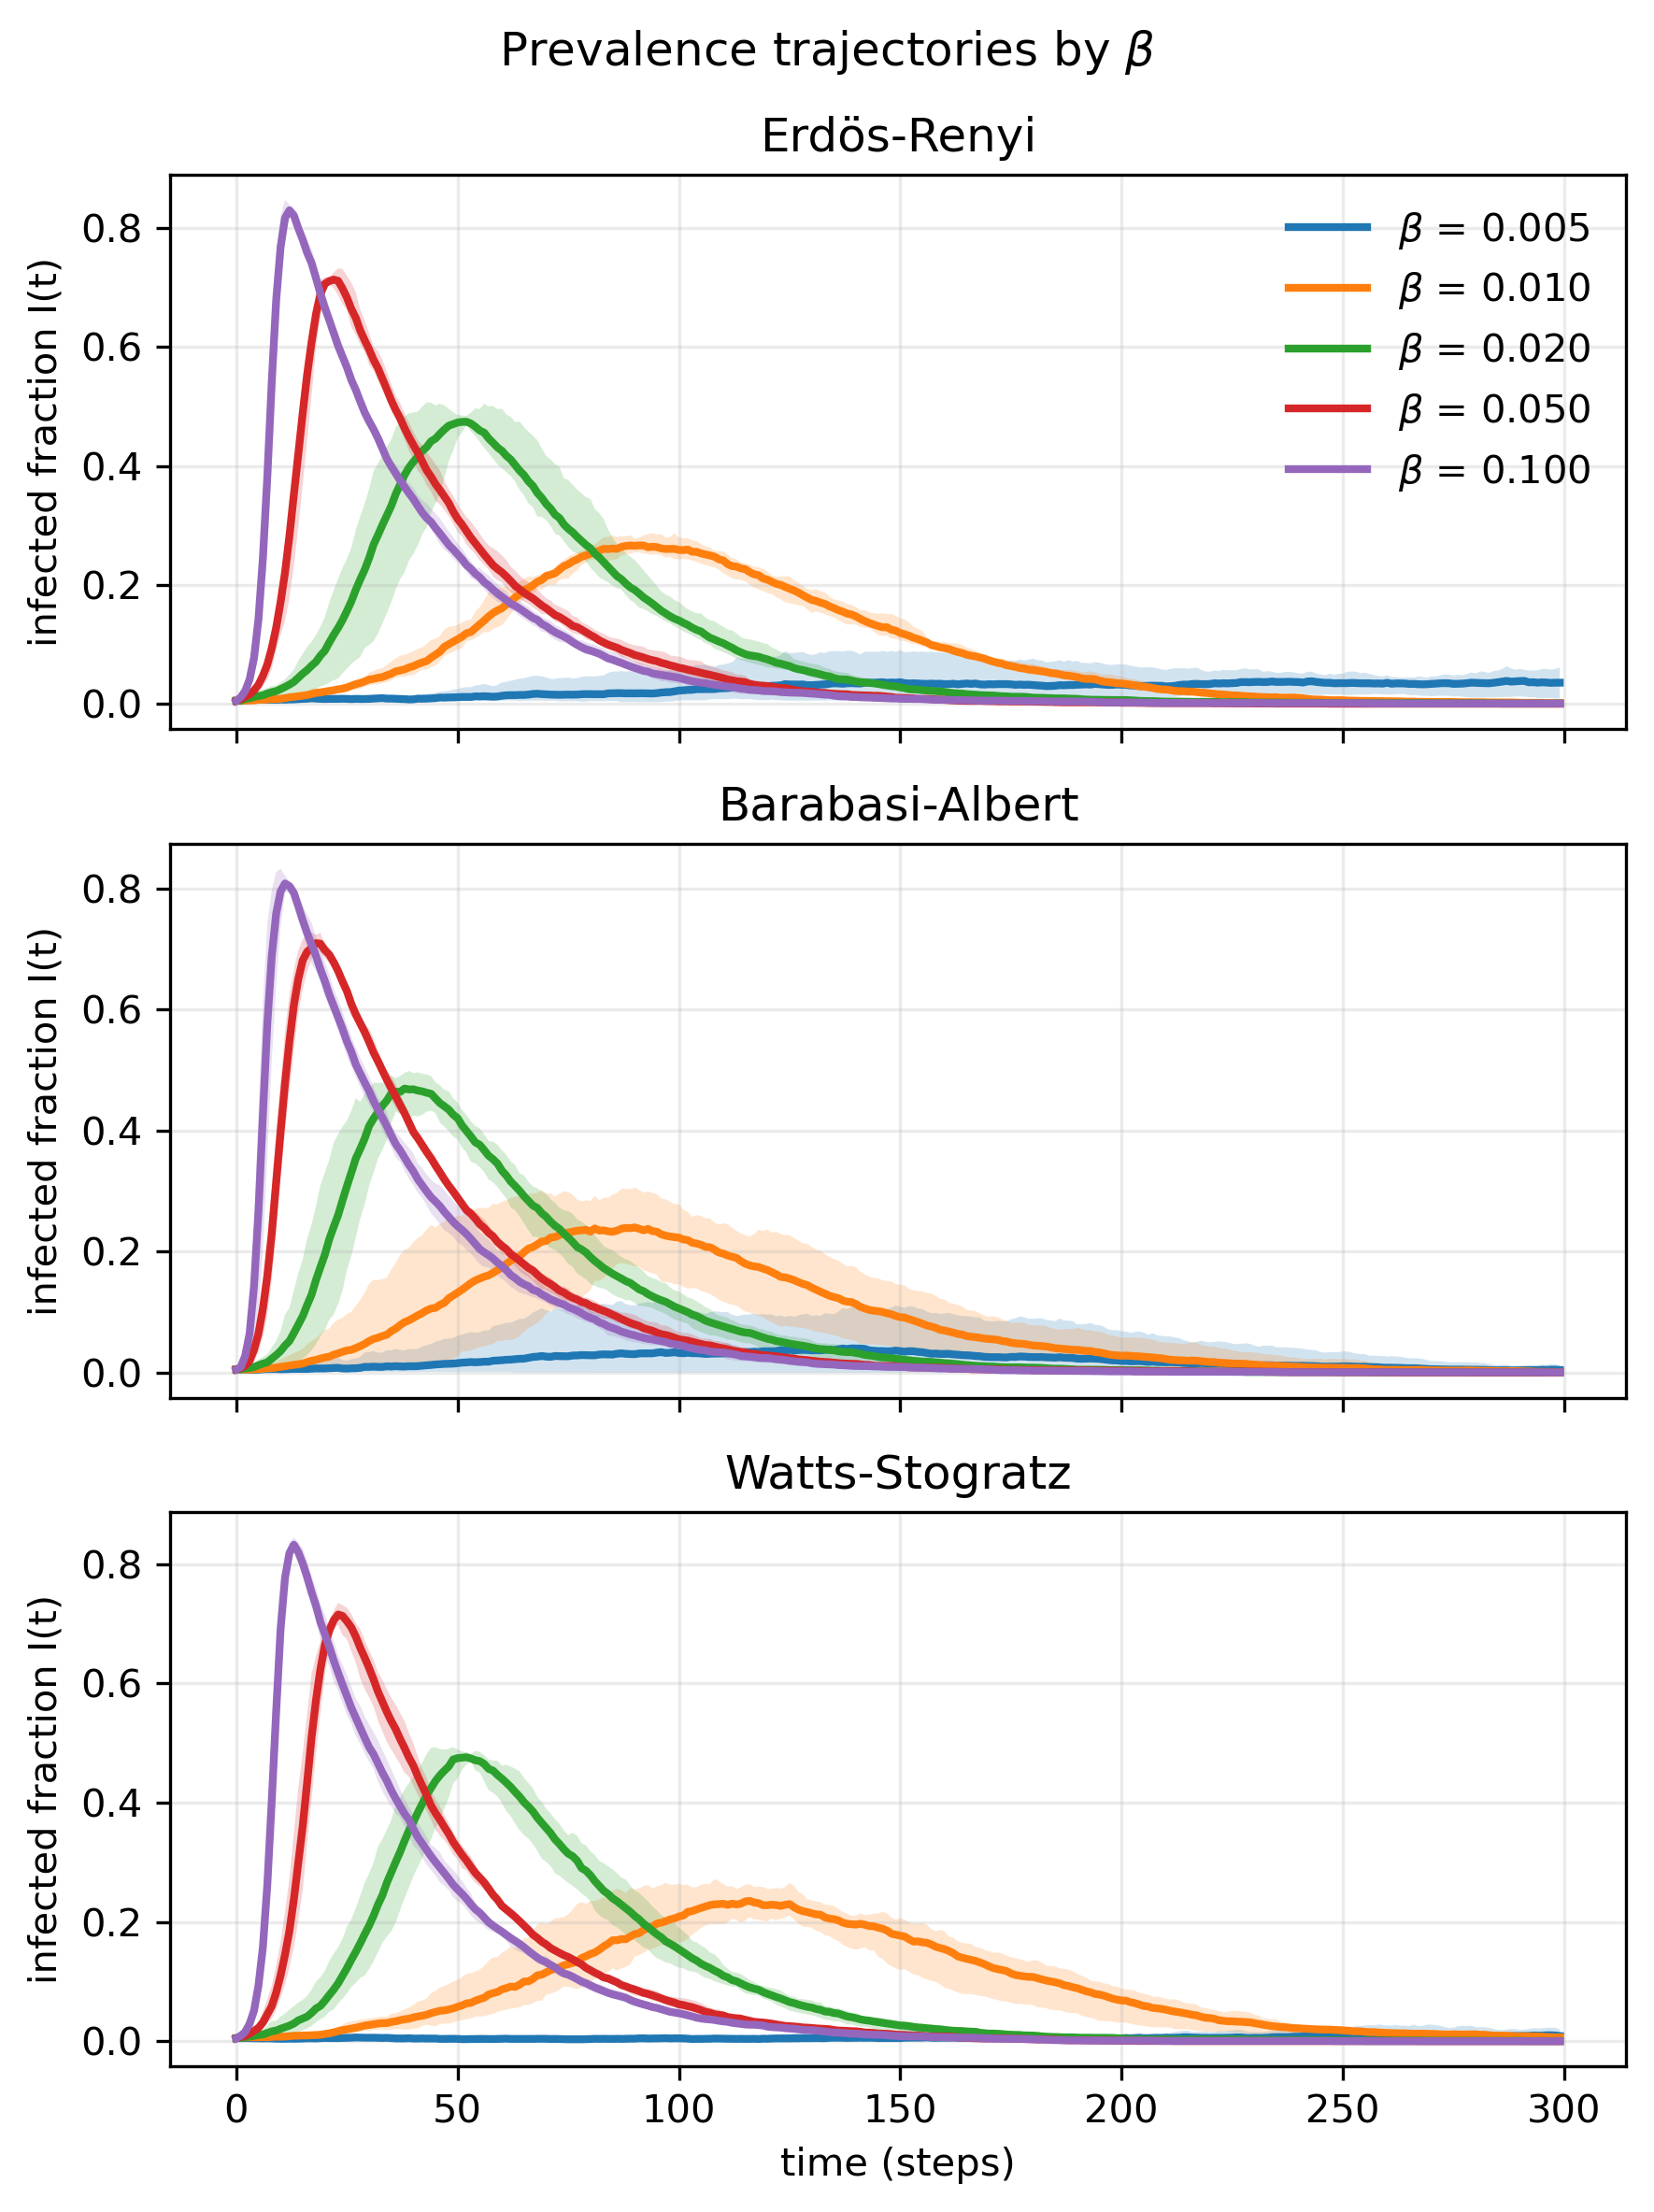

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), dpi=300, sharex=True)

# test plot beta sweeps
for i, beta_sweep in enumerate(beta_sweeps):
    for beta in betas:
        res = beta_sweep[beta]
        axes[i].fill_between(res['t_grid'], res['I_lo'], res['I_hi'], alpha=0.2)
        axes[i].plot(res["t_grid"], res['I_mean'], lw=2, label=fr"$\beta$ = {float(beta):.3f}")
        axes[i].set_ylabel("infected fraction I(t)")
        axes[i].grid(alpha=0.25)
        
axes[0].legend(frameon=False)       
axes[2].set_xlabel("time (steps)")

fig.suptitle(r"Prevalence trajectories by $\beta$")
axes[0].set_title('Erdös-Renyi')
axes[1].set_title('Barabasi-Albert')
axes[2].set_title('Watts-Stogratz')


fig.tight_layout()


In [34]:
def network_attack(network, beta, gamma, R, Y, T):
    """
    Simulate SIR model on network with targeted attack (top degree nodes infected).
    
    Parameters:
    network : networkx Graph object
    beta : infection rate
    gamma : recovery rate
    R : number of simulation runs
    Y : number of initial infected nodes
    T : number of time steps
    
    Returns:
    dict with summary statistics of the simulations
    """
    # pick top Y degree nodes as initial infections
    infected_nodes = top_degree_nodes(network)[0:Y]
    results = {}
    
    # run batch simulations
    I_mat = run_batch(network, beta, gamma, T, infected_nodes, R)
    
    # compute summary statistics
    peak = I_mat.max(axis=1)
    t_peak = I_mat.mean(axis=0).argmax(axis=0)
    outbreak_prob = (I_mat.max(axis=1) >= 0.01).mean()

    results = dict(
    I_mean = I_mat.mean(axis=0),
    I_lo = np.percentile(I_mat, 2.5, axis=0),
    I_hi = np.percentile(I_mat, 97.5, axis=0),
    peak = peak,
    t_peak = t_peak,
    outbreak_prob = float(outbreak_prob),
    t_grid = np.arange(T)
)
    return results 

def network_failure(network, beta, gamma, R, Y, T):
    """
    Simulate SIR model on network with random failure (random nodes infected).
    
    Parameters:
    network : networkx Graph object
    beta : infection rate
    gamma : recovery rate
    R : number of simulation runs
    Y : number of initial infected nodes
    T : number of time steps
    
    Returns:
    dict with summary statistics of the simulations
    """
    # pick Y random nodes as initial infections
    infected_nodes = random_k_nodes(network, Y, 1)
    results = {}
    
    # run batch simulations
    I_mat = run_batch(network, beta, gamma, T, infected_nodes, R)
    
    # compute summary statistics
    peak = I_mat.max(axis=1)
    t_peak = I_mat.mean(axis=0).argmax(axis=0)
    outbreak_prob = (I_mat.max(axis=1) >= 0.01).mean()

    results = dict(
    I_mean = I_mat.mean(axis=0),
    I_lo = np.percentile(I_mat, 2.5, axis=0),
    I_hi = np.percentile(I_mat, 97.5, axis=0),
    peak = peak,
    t_peak = t_peak,
    outbreak_prob = float(outbreak_prob),
    t_grid = np.arange(T)
)
    return results


In [35]:
def plot_network_sweeps(sweeps, title, parameter=None):
    fig, axes = plt.subplots(len(sweeps), 1, figsize=(6, 8), dpi=300, sharex=True)
    for i, result in enumerate(sweeps):
        
        if parameter=="beta":
            label = r"$\beta$"
        elif parameter =="Y":
            label = "$Y$"
        
        if parameter:
            for key in result.keys():
                res = result[key]
                axes[i].fill_between(res['t_grid'], res['I_lo'], res['I_hi'], alpha=0.2)
                
                if parameter == "beta":
                    axes[i].plot(res["t_grid"], res['I_mean'], lw=1, label=fr"{label} = {float(key):.3f}")
                elif parameter == "Y":
                    axes[i].plot(res["t_grid"], res['I_mean'], lw=1, label=f"{label} = {key}")
                    
                axes[i].set_ylabel("infected fraction I(t)")
                axes[i].grid(alpha=0.25)
            axes[0].legend(frameon=False)
            axes[2].set_xlabel("time (steps)")
            axes[2].set_title('Watts-Stogratz')
            
        else:
            axes[i].fill_between(result['t_grid'], result['I_lo'], result['I_hi'], alpha=0.2)
            axes[i].plot(result["t_grid"], result['I_mean'], lw=1, label=f"$I$ peak time = {result['t_peak']}")
            axes[i].set_ylabel("infected fraction I(t)")
            axes[i].grid(alpha=0.25) 
            axes[i].legend(frameon=False)
            axes[1].set_xlabel("time (steps)")

    fig.suptitle(title)
    axes[0].set_title('Erdös-Renyi')
    axes[1].set_title('Barabasi-Albert')
    
    


    fig.tight_layout()


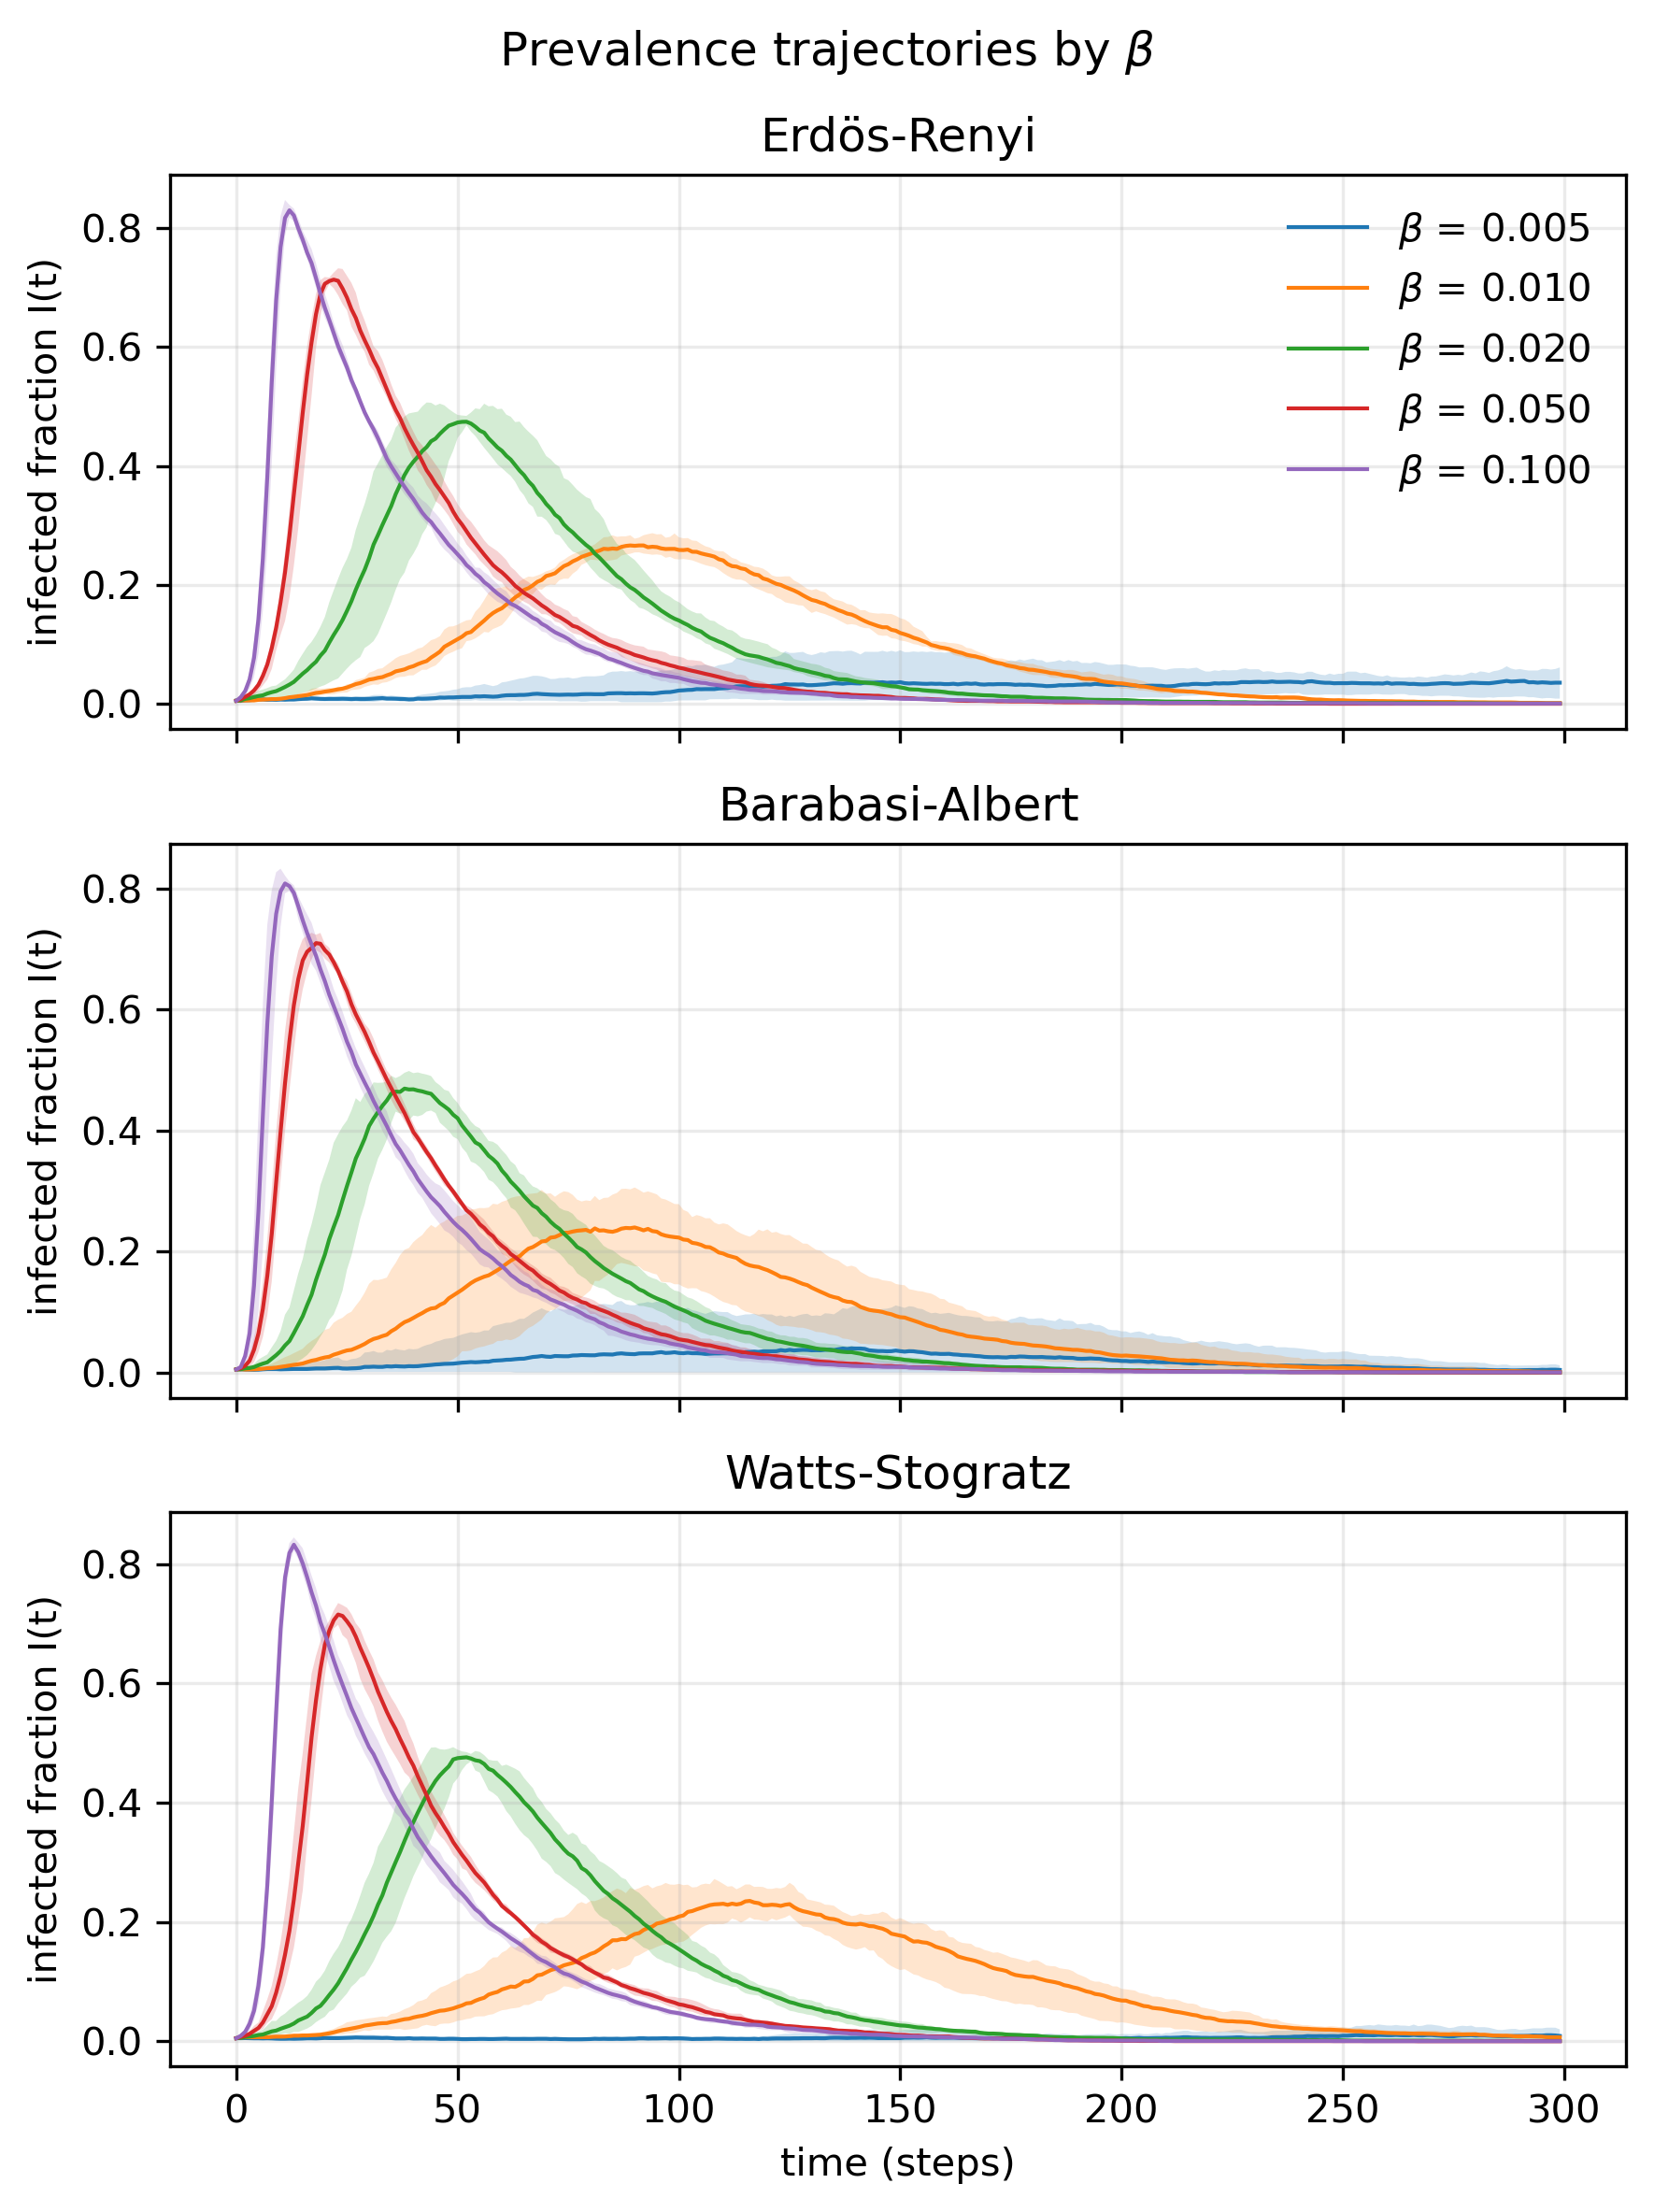

In [36]:
plot_network_sweeps(sweeps=beta_sweeps, title=r"Prevalence trajectories by $\beta$", parameter="beta")

In [37]:
R, Y, T = 30, 5, 300
beta, gamma = 0.01, 0.033
attack_results = (network_attack(ER, beta, gamma, R, Y, T), network_attack(BA, beta, gamma, R, Y, T))

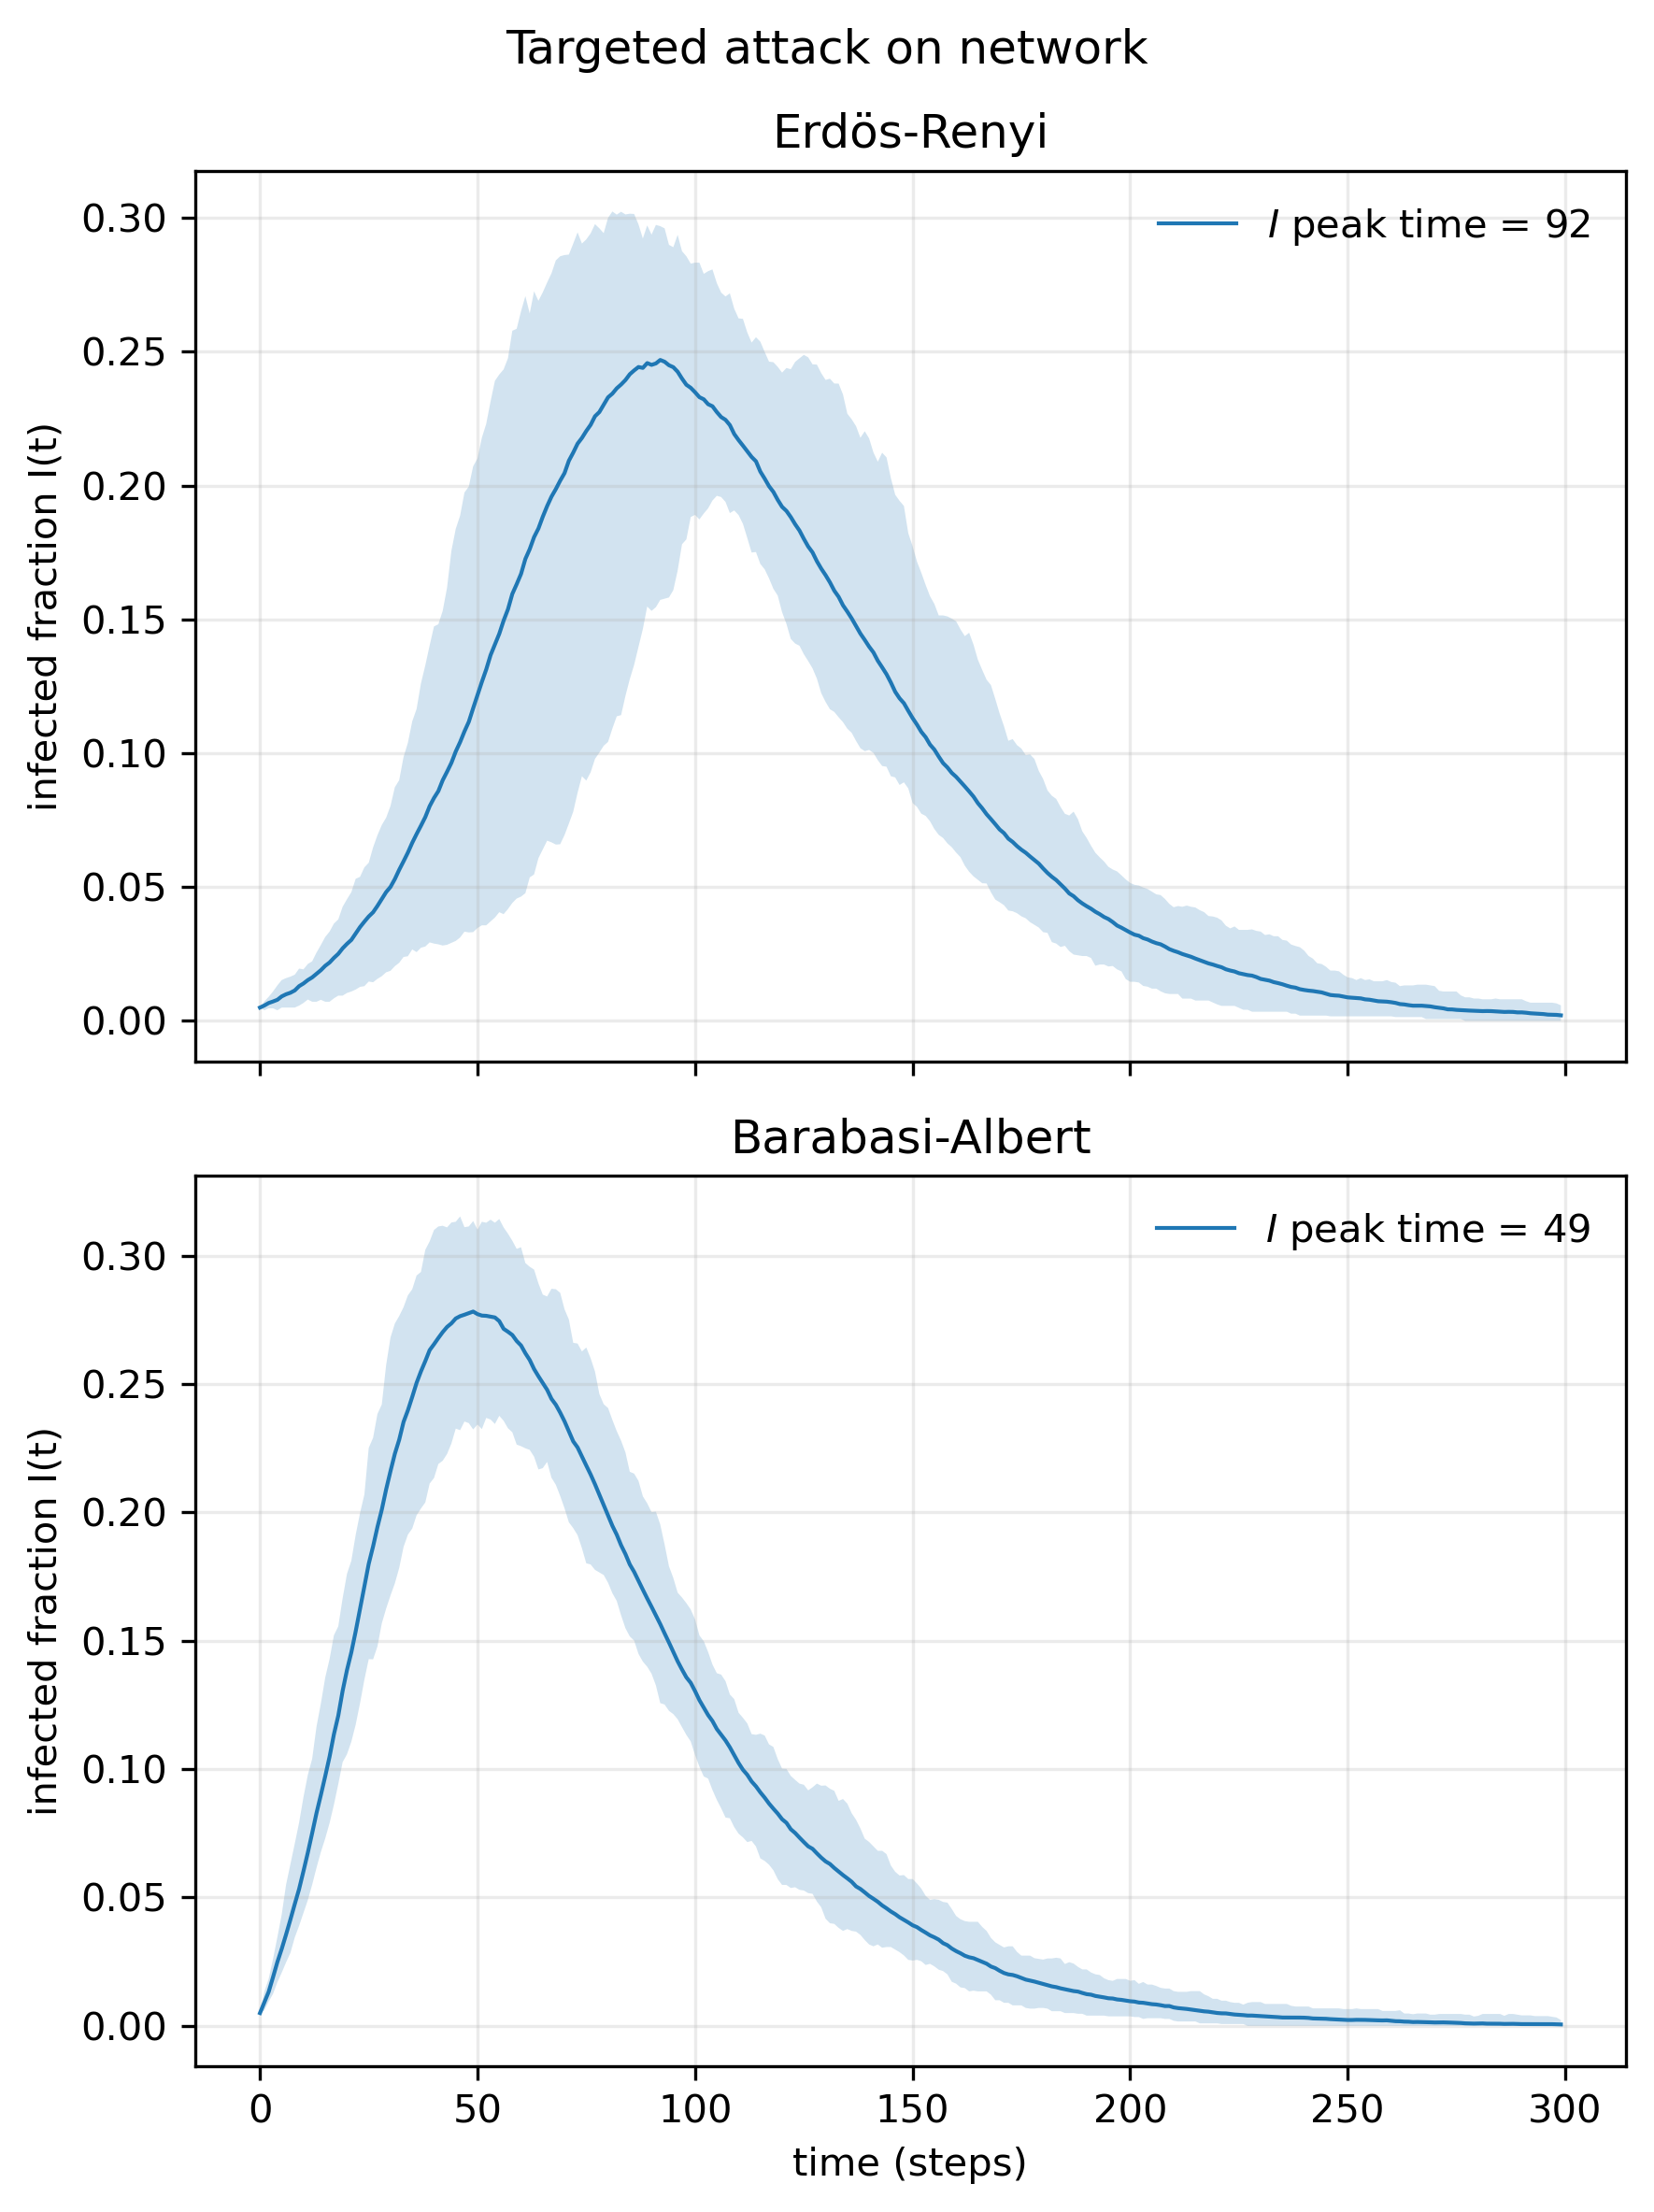

In [38]:
plot_network_sweeps(attack_results, title=r"Targeted attack on network")

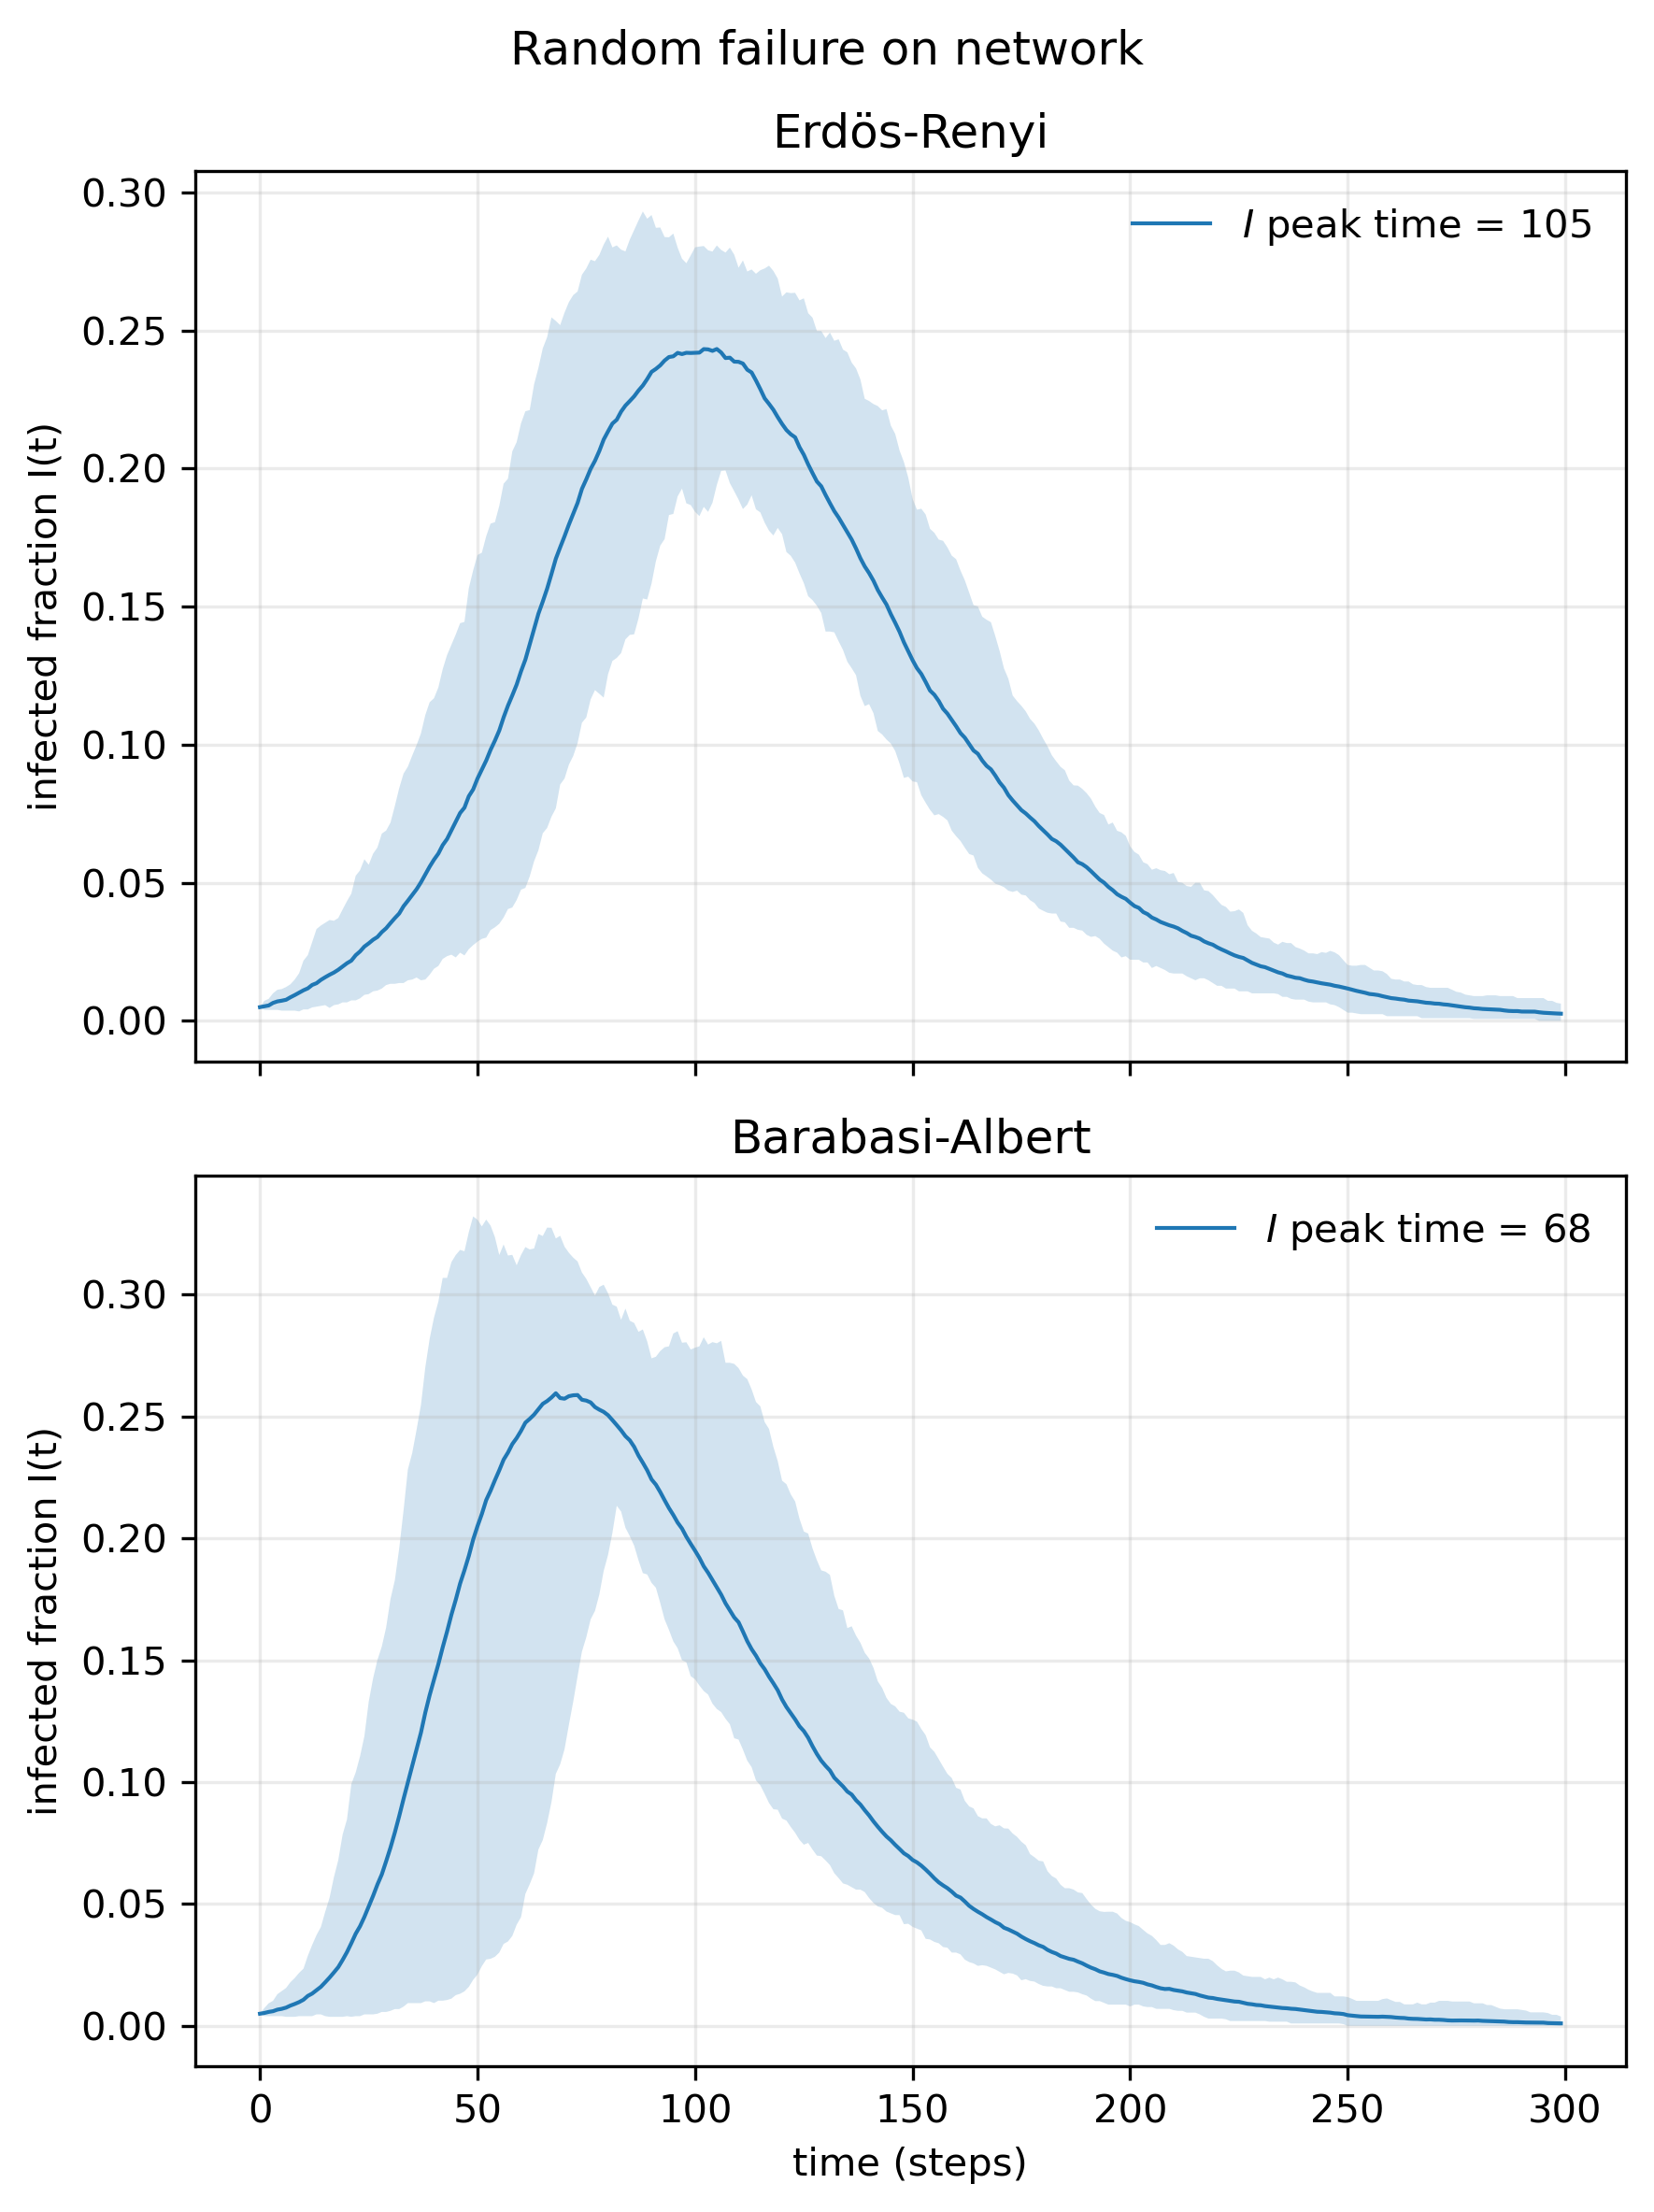

In [39]:
failure_results = (network_failure(ER, beta, gamma, R, Y, T), network_failure(BA, beta, gamma, R, Y, T))
plot_network_sweeps(failure_results, title=r"Random failure on network")

In [40]:
def Y_sweep_(network, beta, gamma, R, Y_array, T):
    """
    Perform a sweep over amount of initial infected nodes Y on the SIR model over the given network.
    
    Parameters:
    network : networkx Graph object
    beta : infection rate
    gamma : recovery rate
    R : number of simulation runs per Y
    Y_array : array of Y values (starting amount of infetious) to sweep over
    T : number of time steps per simulation
    
    Returns:
    dict mapping Y values to summary statistics
    """
    results = {}
    
    # loop over Y values
    for Y in Y_array:
        
        # select initial infected nodes randomly
        infected_nodes = random_k_nodes(network, Y, 1)
        
        # run batch simulations
        I_mat = run_batch(network, beta, gamma, T, infected_nodes, R)
        
        # compute summary statistics
        peak = I_mat.max(axis=1)
        t_peak = I_mat.argmax(axis=1)
        outbreak_prob = (I_mat.max(axis=1) >= 0.01).mean()

        results[Y] = dict(
        I_mean = I_mat.mean(axis=0),
        I_lo = np.percentile(I_mat, 2.5, axis=0),
        I_hi = np.percentile(I_mat, 97.5, axis=0),
        peak = peak,
        t_peak = t_peak,
        outbreak_prob = float(outbreak_prob),
        t_grid = np.arange(T)
    )
    
    
    return results

In [41]:
# perform Y sweeps
R, T = 30, 300
beta, gamma = 0.01, 0.033
Y = [1, 5, 10]
Y_sweep = (Y_sweep_(ER, beta, gamma, R, Y, 300), Y_sweep_(BA, beta, gamma, R, Y, 300), Y_sweep_(WS, beta, gamma, R, Y, 300))

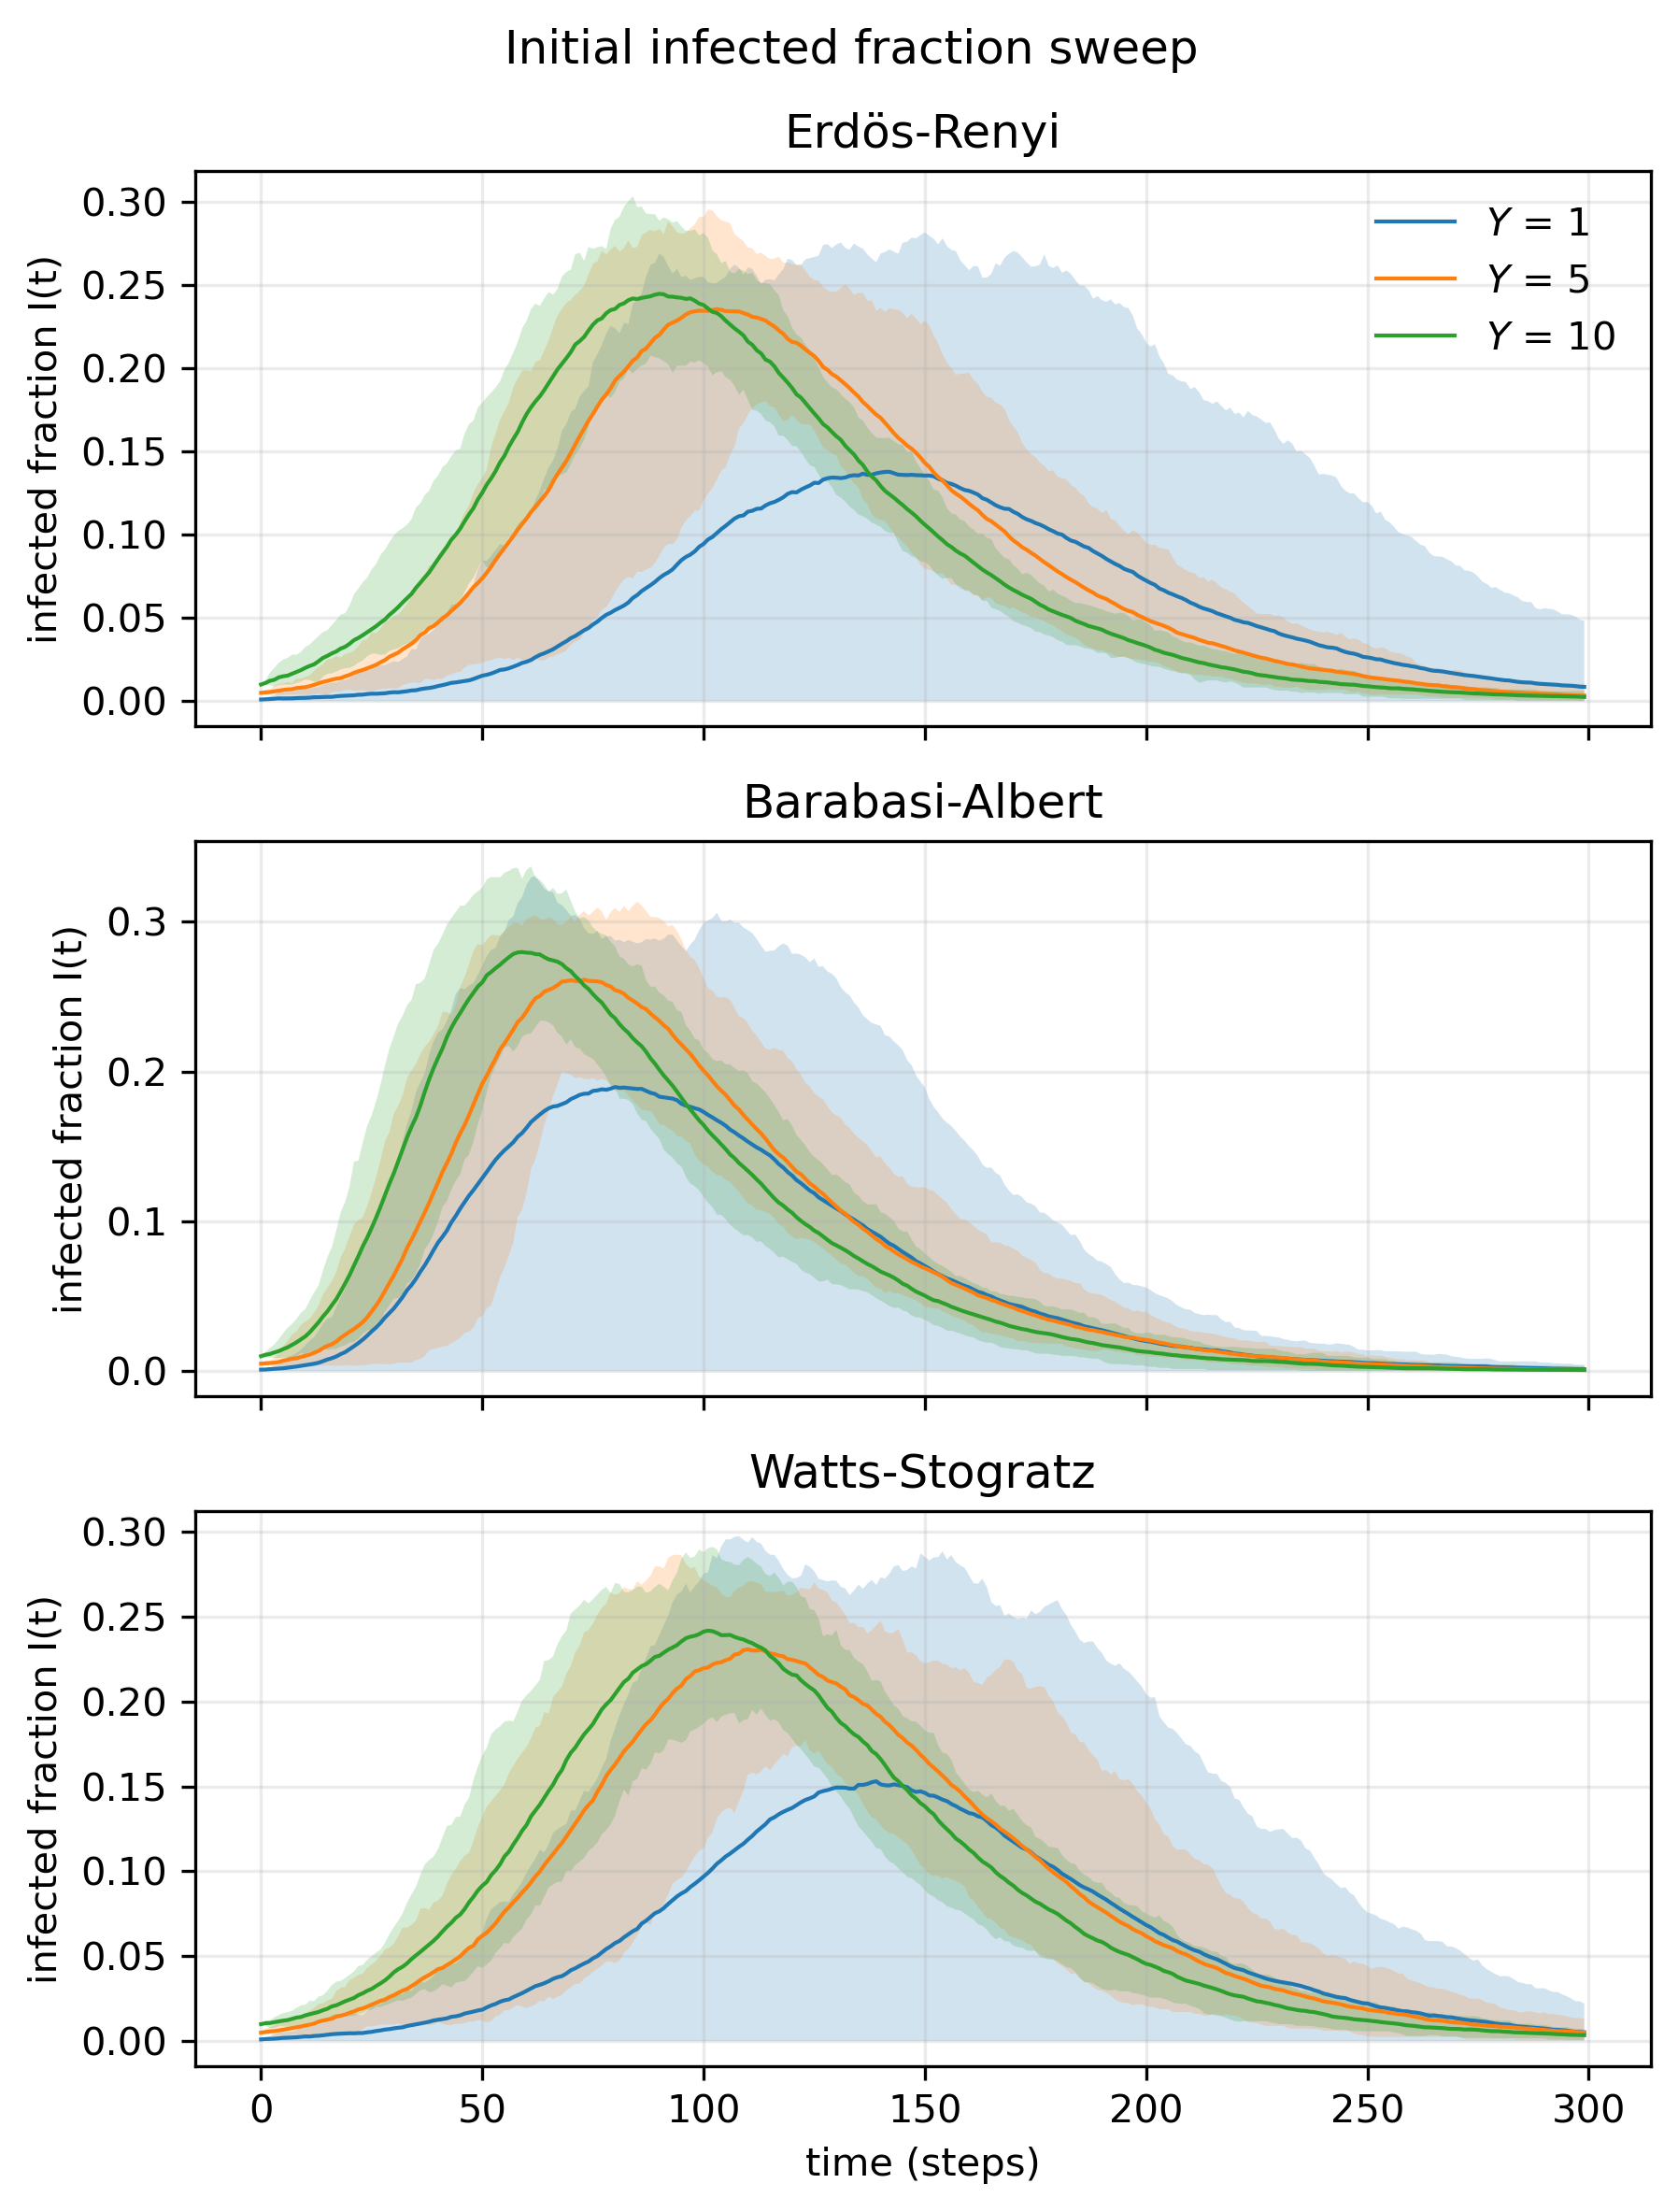

In [42]:
# plot y sweeps
plot_network_sweeps(Y_sweep, title=r"Initial infected fraction sweep", parameter="Y")

In [43]:
# load transmission network from CSV adjacency list
G = nx.read_adjlist("transmission_network.csv", delimiter=';')

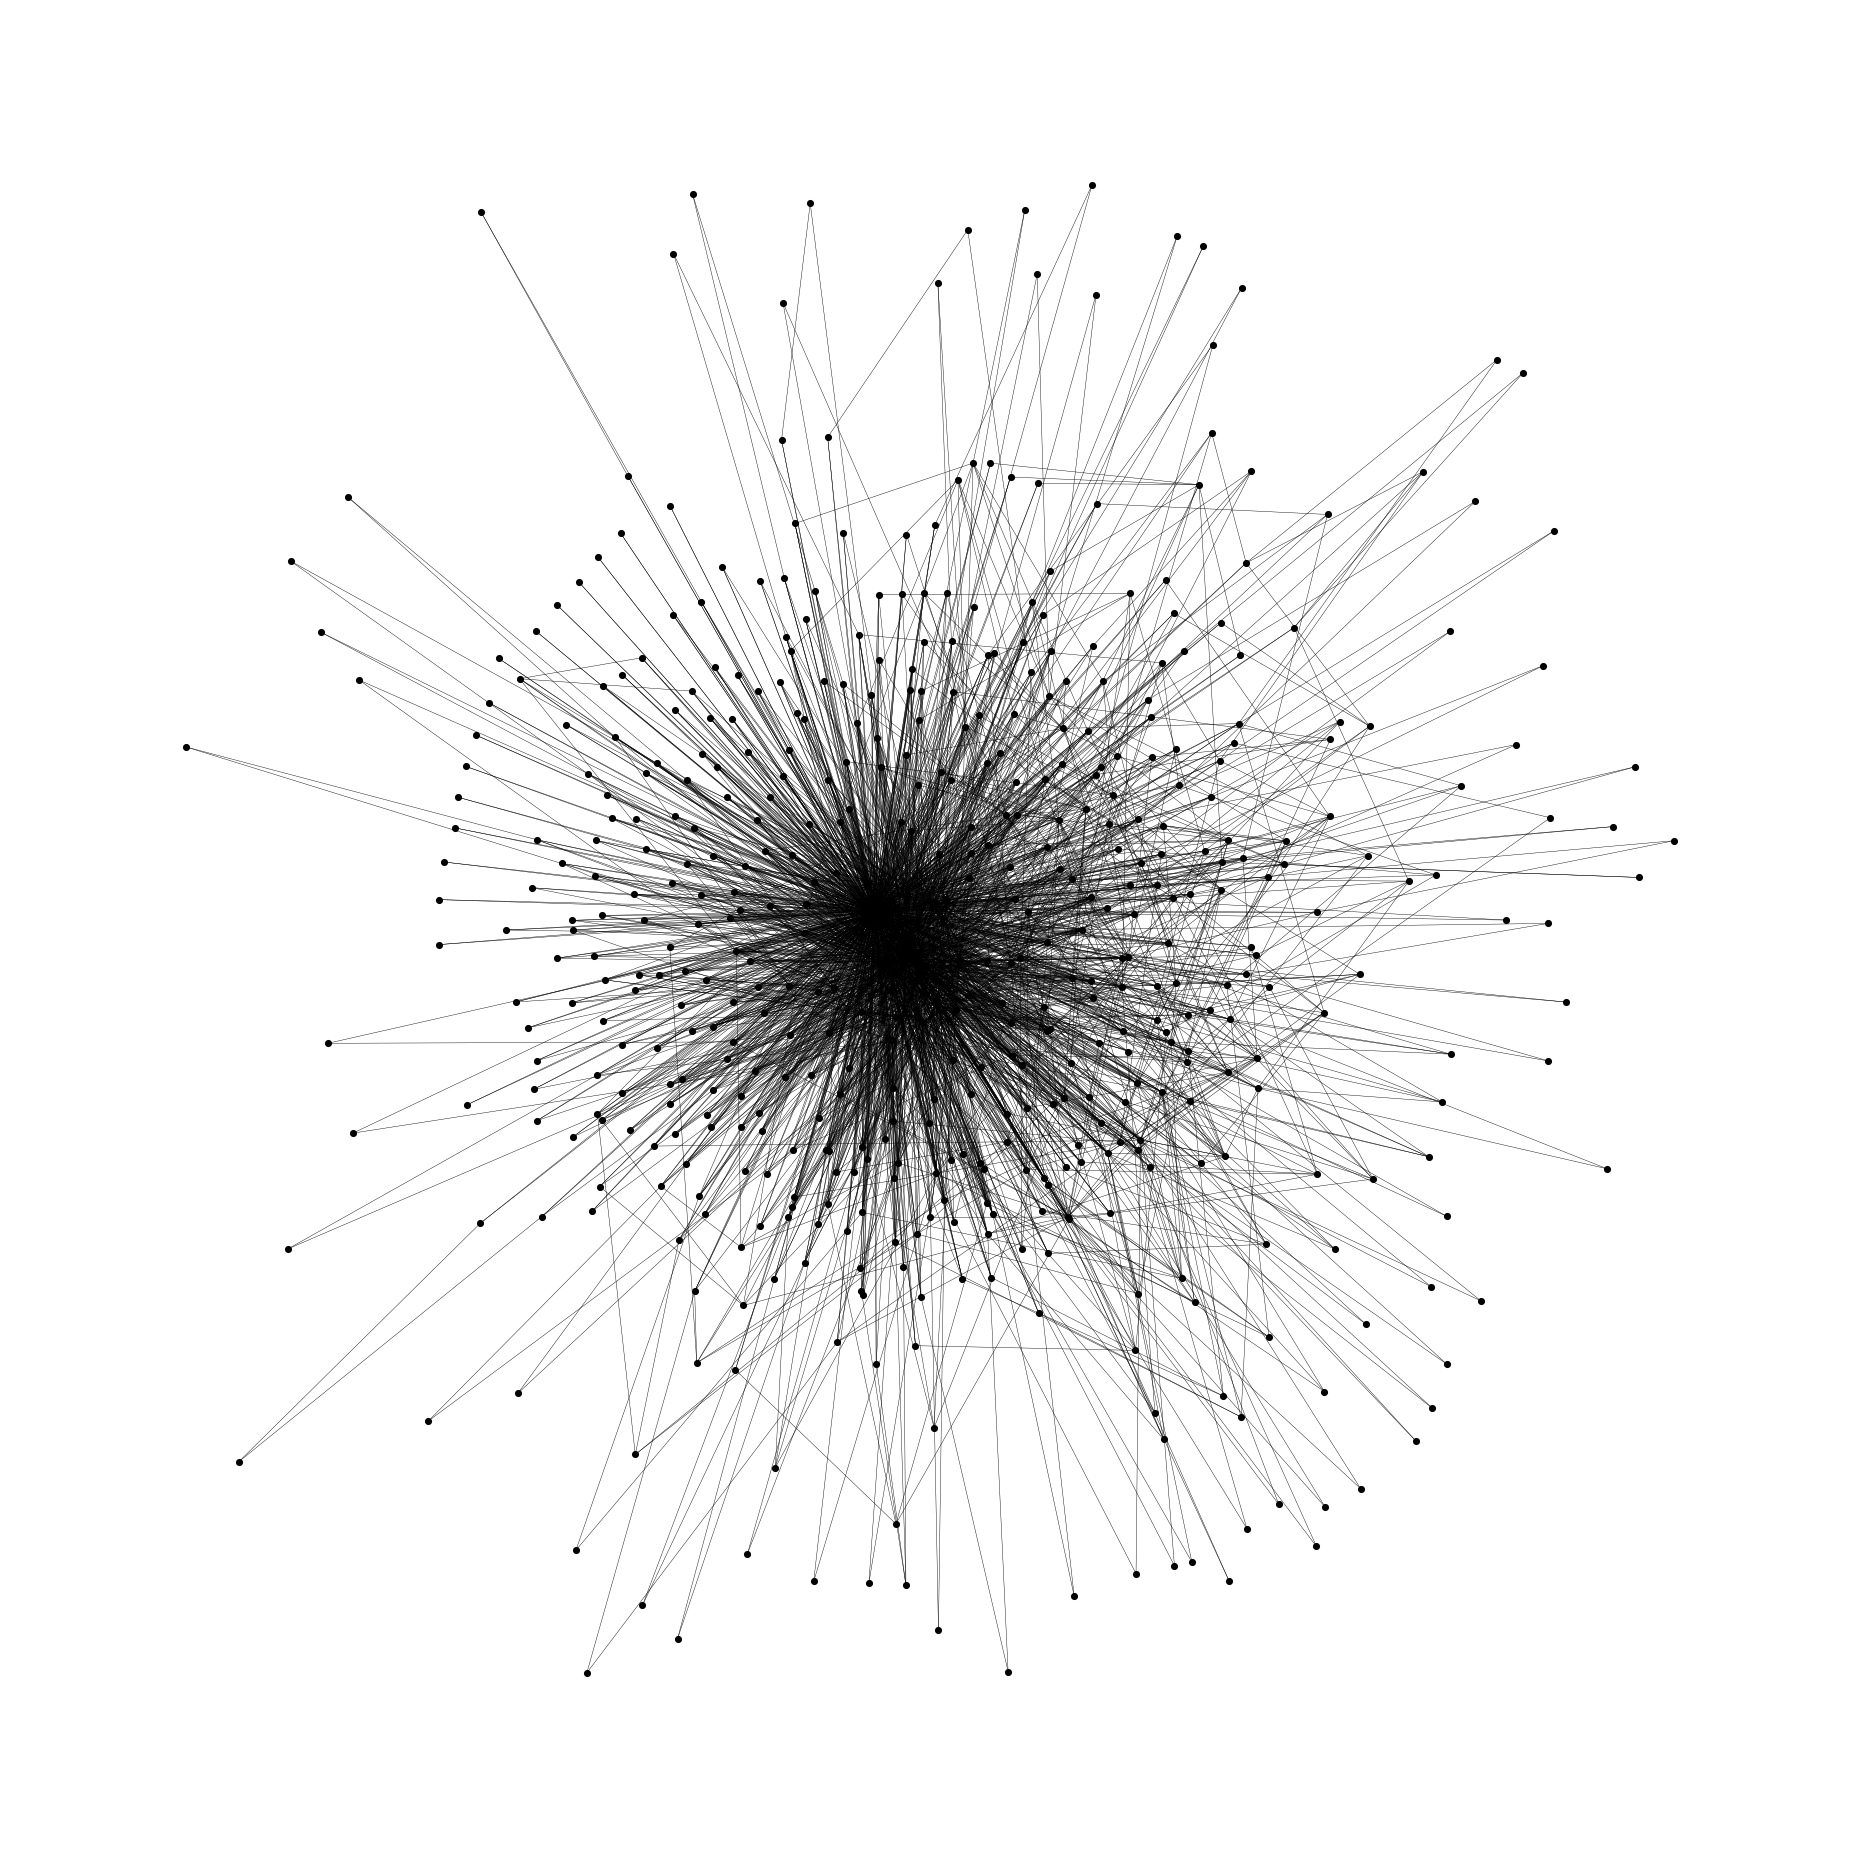

In [44]:
# test plot of transmission network for reference
plt.figure(figsize=(6,6), dpi=300)
nx.draw(G, node_size=0.5, width=0.1, with_labels=False, node_color='black')
plt.axis("off")
plt.show()

In [ ]:
class Vacc_Campaign:
    """
    Class to simulate vaccination campaign on a network using SIR model.
    
    Attributes:
    beta : infection rate
    gamma : recovery rate
    G : networkx Graph object
    seed : random seed for reproducibility
    
    Methods:
    reset_seed() : resets random number generators
    random_init_inf(amount) : selects random initial infected nodes
    configure_model() : configures the SIR model
    test_nodes(budget, test_acc_prob) : tests nodes and updates beliefs about infections
    vacc_nodes(budget, random) : vaccinates nodes based on beliefs or randomly
    """
    def __init__(self, beta, gamma, network, seed):
        self.gamma = gamma
        self.beta = beta
        self.G = network
        self.seed = seed
        
    def reset_seed(self):
        self.rng_init_inf = np.random.default_rng(self.seed)
        self.rng_test = np.random.default_rng(self.seed * 53)
        self.rng_random = np.random.default_rng(self.seed*123)
        
    def random_init_inf(self, amount=5):             
        return self.rng_init_inf.choice(list(self.G.nodes()), amount, replace=False).tolist()
    
    def configure_model(self):
        self.model = ep.SIRModel(self.G)
        config = mc.Configuration()
        config.add_model_parameter('beta', self.beta)
        config.add_model_parameter('gamma', self.gamma)
        config.add_model_initial_configuration("Infected", self.random_init_inf())
        self.model.set_initial_status(config)
        
        
    def test_nodes(self, budget, test_acc_prob):
        """
        Test nodes in the network to update beliefs about infections. 
        First tests neighbors of believed infected nodes, then fills 
        remaining budget with high-degree untested nodes.
        
        Parameters:
        budget : number of tests available
        test_acc_prob : probability of accurate test result
        """
        # set budget
        k = int(budget)
        
        # build frontier of neighbors of believed infected
        frontier = set()
        for i in self.believed_i:
            frontier.update(self.G.neighbors(i))
        frontier.difference_update(self.believed_i)
        frontier.difference_update(self.vaccinated)

        # first cadidates sorted on degree
        cand1 = sorted(frontier, key=lambda u: (self.G.degree[u], u), reverse=True)[:k]

        # calculate remaining budget
        need = k - len(cand1)
        tested_now = set(cand1)
        
        # second candidates from high-degree untested nodes
        if need > 0:
            pool = [n for n in self.G.nodes()
                    if n not in self.vaccinated and n not in self.believed_i and n not in tested_now]
            cand2 = sorted(pool, key=lambda u: (self.G.degree[u], u), reverse=True)[:need]
        else:
            cand2 = []

        test_nodes = cand1 + cand2

        # update beliefs from **observed** label
        self.tested_S_this_step = set()
        
        for node in test_nodes:
            true = self.model.status[node]          # 0=S, 1=I, 2=R
            r = self.rng_test.random()
            
            # determine observed label with test accuracy
            obs = true if r <= test_acc_prob else ((1-true) if true in (0,1) else 2)
            
            if obs == 1:
                self.believed_i.add(node)
            
            else:
                
                # use negative info so don't let false positives be in i_believed
                self.believed_i.discard(node)
                if obs == 0:
                    self.tested_S_this_step.add(node)
       
    def vacc_nodes(self, budget, random=False):
        """
        Vaccinate nodes based on beliefs or randomly.
        
        Parameters:
        budget : number of vaccines available
        random : if True, vaccinate random nodes; else vaccinate based on beliefs
        """
        
        # select vaccinees
        if not random and self.believed_i:
            
            # build frontier of neighbors of believed infected
            F = set()
            for node in self.believed_i:
                F.update(self.G.neighbors(node))
            F.difference_update(self.believed_i)
            
            # rank frontier by degree and select top budget
            ranked = [n for n in sorted(F, key=lambda u: (self.G.degree[u], u), reverse=True) if n not in self.vaccinated]
            vaccinees = ranked[:budget]
            
            # if not enough, fill with high-degree unvaccinated nodes
            if len(vaccinees) < budget:
                extra_vaccinees = [n for n in sorted(self.believed_s, key=lambda u: (self.G.degree[u], u), reverse=True) if n not in self.vaccinated]
                vaccinees.extend(extra_vaccinees[:budget - len(vaccinees)])
        
        # random vaccination
        else:    
            unvaccinated = [n for n in list(self.G.nodes) if n not in self.vaccinated]
            k = min(budget, len(unvaccinated))
            vaccinees = self.rng_random.choice(np.array(unvaccinated), k, replace=False)
        
        # vaccinate selected nodes    
        for vaccinee in vaccinees:
            if self.model.status[vaccinee] == 0:
                self.model.status[vaccinee] = 2
                self.vaccinated.add(vaccinee)
                self.vaccinees_n += 1
        
        # record vaccinee trajectory    
        self.vaccinee_trajectory.append(self.vaccinees_n)
            
        
    def run_experiment(self, budget, test_acc, model_seed, random=False):
        """
        Run a single vaccination campaign experiment until no infections remain.
        
        Parameters:
        budget : number of tests/vaccines per iteration
        test_acc : probability of accurate test result
        model_seed : random seed for reproducibility
        random : if True, vaccinate random nodes; else vaccinate based on beliefs
        
        Returns:
        I_trajectory : array of infected fractions over time
        vaccinee_trajectory : array of vaccinee fractions over time
        """
        # infection starting count always 5
        current_inf = 5
        np.random.seed(model_seed)
        
        # initialize beliefs and vaccinees
        self.believed_i = set()
        self.believed_s = set()
        
        self.vaccinees_n = 0
        self.vaccinated = set()
        self.vaccinee_trajectory = [0]
        
        Y_trajectory = [5]
        
        # reset seeds and configure model
        self.reset_seed()
        self.configure_model() 
        
        # as long as infections remain
        while current_inf > 0:
            
            # only test when targeted vaccination
            if not random:
                self.test_nodes(budget, test_acc)
            self.vacc_nodes(budget, random)
            
            # update current infection count
            self.current_it = self.model.iteration()
            current_inf = self.current_it['node_count'][1]
            
            Y_trajectory.append(current_inf)
        
        # convert trajectories to fractions
        I_trajectory = np.array(Y_trajectory, float) / len(self.G.nodes())
        vaccinee_trajectory = np.array(self.vaccinee_trajectory, float) / len(self.G.nodes())
        
        return I_trajectory, vaccinee_trajectory
    
    def run_batch(self, budget, test_acc, model_seed, R, random=False):
        """
        Run multiple vaccination campaign experiments and average the results.
        """
        I_list = []
        V_list = []
        
        for i in range(R):
            I, V = self.run_experiment(budget, test_acc, model_seed+i, random)
            I_list.append(I)
            V_list.append(V)
            
        L = max(len(x) for x in I_list)
        def pad0(a): return np.pad(a, (0, L-len(a)), constant_values=0.0)
        def pad_edge(a): return np.pad(a, (0, L-len(a)), mode="edge")

        I_mat = np.vstack([pad0(x)     for x in I_list])
        V_mat = np.vstack([pad_edge(x) for x in V_list])
        
        I_mean = I_mat.mean(axis=0)
        V_mean = V_mat.mean(axis=0)
        
        return I_mean, V_mean
        
    
    def parameter_sweep(self, acc_list, budget_list, R):
        """
        Perform parameter sweeps over test accuracy and vaccination budget.
        
        Parameters:
        acc_list : list of test accuracy probabilities to sweep over
        budget_list : list of vaccination budgets to sweep over
        R : number of simulation runs per parameter setting
        Returns:
        dict with results of the sweeps
        """
        
        trajectories_dict = {'acc_sweep': {'random':{}, 'targeted':{}}, 'budget_sweep': {'random':{}, 'targeted':{}}}
        
        for acc in acc_list:
           
            trajectories_dict['acc_sweep']['random'][acc] = self.run_batch(10, acc, 1, R , random=True)
            trajectories_dict['acc_sweep']['targeted'][acc] = (self.run_batch(10, acc, 1, R))
        
        for budget in budget_list:
            trajectories_dict['budget_sweep']['random'][budget] = self.run_batch(budget, 1, 1, R, random=True)
            trajectories_dict['budget_sweep']['targeted'][budget] = self.run_batch(budget, 1, 1, R)
            
        return trajectories_dict
        

        

In [ ]:
# parameter sweep test
acc_list = [0.5, 0.75, 1]
budget_list = [1, 3, 5, 10]
vacc_experiment = Vacc_Campaign(0.01, 0.0033, G, 1)
trajectories = vacc_experiment.parameter_sweep(acc_list, budget_list, 10)

random
targeted
dict_keys(['random', 'targeted'])


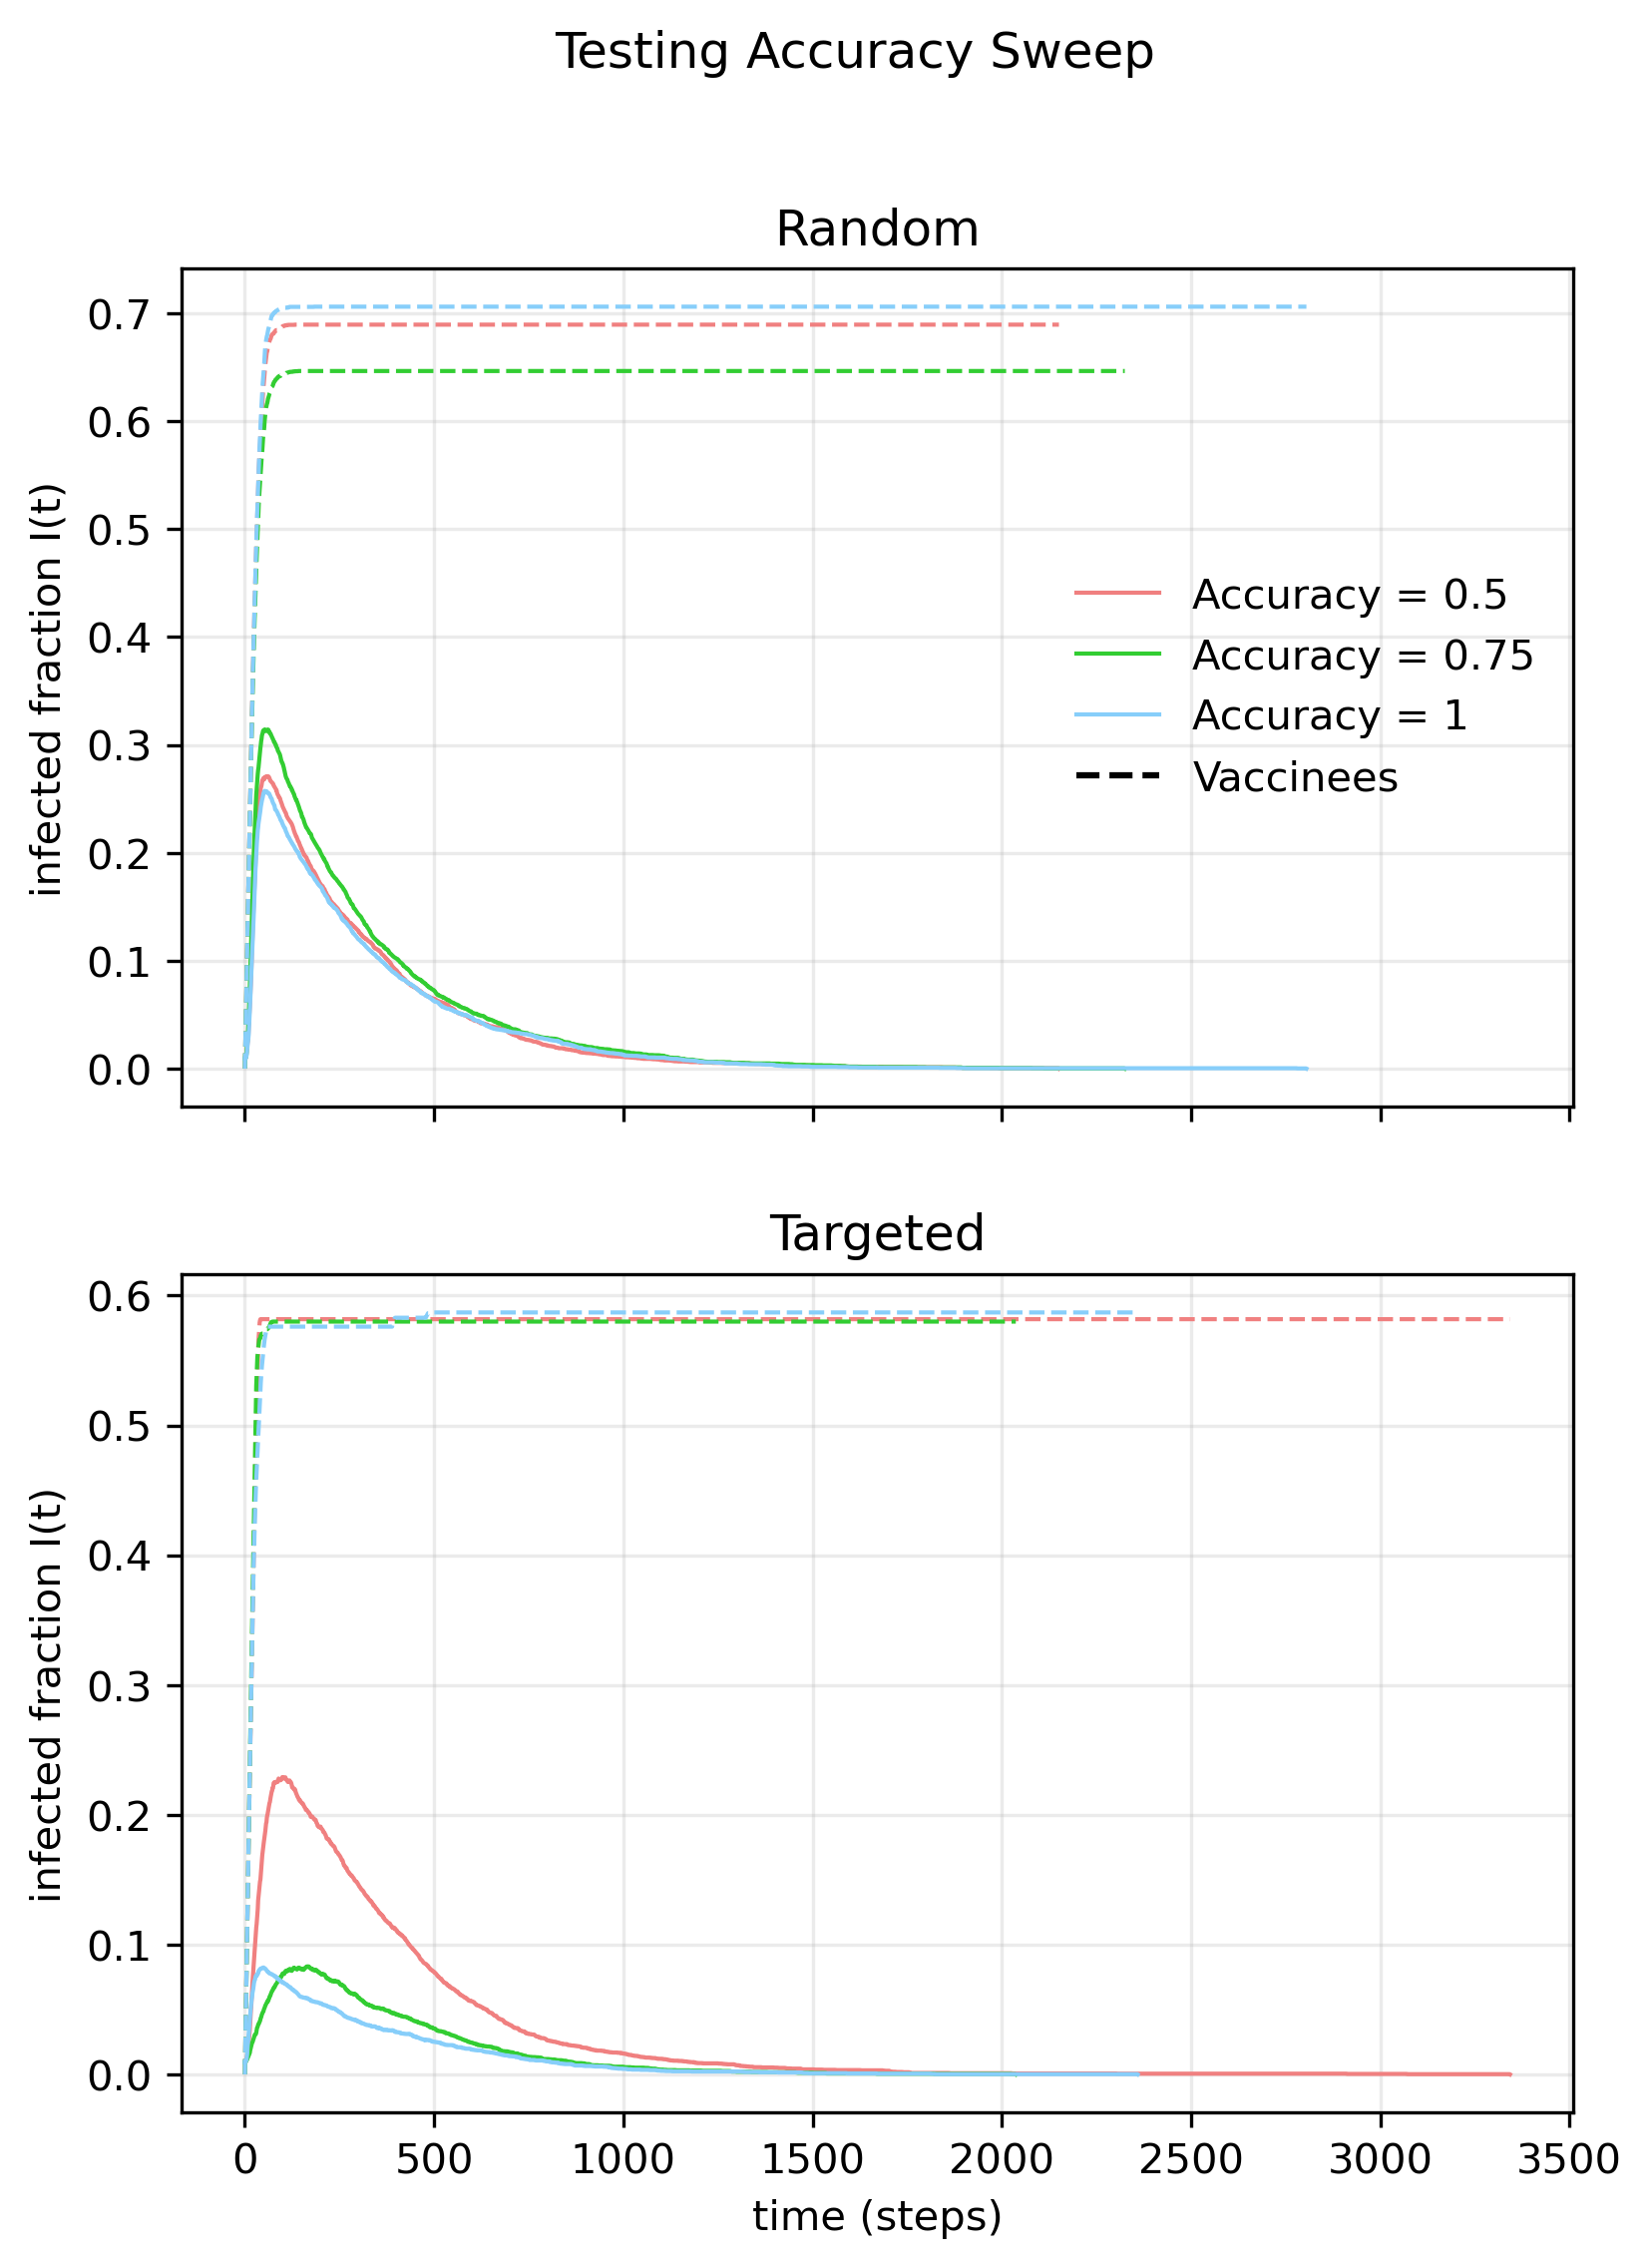

In [ ]:
def plot_vacc_sweep(trajectories, sweep_kind, title):
    """
    Plot vaccination campaign parameter sweeps.
    
    Parameters:
    trajectories : dict with sweep results
    sweep_kind : str, either "acc_sweep" or "budget_sweep"
    title : title for the plot
    
    Returns:
    None (displays plot)
    """
    
    if sweep_kind == "budget_sweep":
        label = "Budget"
    else:
        label = "Accuracy"
    
    colors = ["lightcoral", "limegreen", "lightskyblue", "fuchsia"]
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), dpi=300, sharex=True)
    
    for i, vacc_method in enumerate(trajectories[sweep_kind]):
        print(vacc_method)
        for c, val in enumerate(trajectories[sweep_kind][vacc_method].keys()):
            res = trajectories[sweep_kind][vacc_method][val]
            t_grid = np.arange(len(res[0]))
            axes[i].plot(t_grid, res[1], lw=1, ls= '--', color=colors[c])
            axes[i].plot(t_grid, res[0], lw=1, color= colors[c], label=f"{label} = {val}")
            axes[i].set_ylabel("infected fraction I(t)")
            axes[i].grid(alpha=0.25)
     
    axes[0].set_title("Random")
    axes[1].set_title("Targeted")       
    axes[0].plot([], [], ls='--', color='k', label='Vaccinees')
    axes[0].legend(frameon=False)            
    axes[1].set_xlabel("time (steps)")
    fig.suptitle(title)

plot_vacc_sweep(trajectories, "acc_sweep", "Testing Accuracy Sweep")
print(trajectories["acc_sweep"].keys())

In [335]:
ER = nx.erdos_renyi_graph(1000, 0.1)
sir_er = ep.SIRModel(ER)
config = mc.Configuration()
config.add_model_parameter("beta", 1)
config.add_model_parameter('gamma', 1/3)
config.add_model_parameter("fraction_infected", 0.8)
sir_er.set_initial_status(config)

print(ER.nodes())


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [330]:
iteration = sir_er.iteration()
info = sir_er.get_info()
print(info)
status = sir_er.get_status_map()
print(status)

# trends = sir_er.build_trends(iterations)


{'beta': 1, 'gamma': 0.3333333333333333, 'fraction_infected': 0.8, 'tp_rate': 1}
{'Susceptible': 0, 'Infected': 1, 'Removed': 2}


In [332]:
print(iteration)
print(sir_er.status)
trends = sir_er.build_trends(iteration)
print(trends)


{'iteration': 2, 'status': {1: 2, 5: 2, 6: 2, 9: 2, 14: 2, 16: 2, 17: 2, 19: 2, 24: 2, 25: 2, 41: 2, 51: 2, 54: 2, 55: 2, 57: 2, 67: 2, 72: 2, 74: 2, 77: 2, 82: 2, 85: 2, 87: 2, 88: 2, 89: 2, 92: 2, 97: 2, 99: 2, 102: 2, 107: 2, 108: 2, 109: 2, 110: 2, 113: 2, 118: 2, 120: 2, 128: 2, 131: 2, 132: 2, 139: 2, 143: 2, 151: 2, 152: 2, 156: 2, 157: 2, 163: 2, 166: 2, 171: 2, 186: 2, 196: 2, 198: 2, 201: 2, 211: 2, 233: 2, 234: 2, 235: 2, 239: 2, 240: 2, 242: 2, 247: 2, 248: 2, 254: 2, 271: 2, 278: 2, 279: 2, 281: 2, 283: 2, 284: 2, 285: 2, 286: 2, 293: 2, 294: 2, 299: 2, 313: 2, 318: 2, 319: 2, 321: 2, 322: 2, 325: 2, 337: 2, 338: 2, 340: 2, 358: 2, 363: 2, 364: 2, 370: 2, 379: 2, 382: 2, 389: 2, 400: 2, 401: 2, 402: 2, 406: 2, 411: 2, 428: 2, 434: 2, 437: 2, 443: 2, 450: 2, 451: 2, 463: 2, 465: 2, 467: 2, 472: 2, 473: 2, 475: 2, 489: 2, 492: 2, 497: 2, 499: 2, 500: 2, 505: 2, 508: 2, 509: 2, 510: 2, 512: 2, 514: 2, 515: 2, 519: 2, 524: 2, 526: 2, 527: 2, 532: 2, 545: 2, 546: 2, 548: 2, 551

TypeError: string indices must be integers